#📚 Librerías necesarias

In [ ]:
!pip install torch==1.7.1 
!pip install torchvision==0.8.2 
!pip install matplotlib 
!pip install scikit-image 
!pip install opencv-python
!pip install yacs
!pip install joblib 
!pip install natsort 
!pip install h5py 
!pip install tqdm
!pip install einops
!pip install linformer
!pip install timm
!pip install ptflops
!pip install dataclasses

     |████████████████████████████████| 776.8 MB 16 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu102 requires torch==1.9.0, but you have torch 1.7.1 which is incompatible.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.7.1 which is incompatible.
     |████████████████████████████████| 12.8 MB 6.7 MB/s 
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
     |████████████████████████████████| 376 kB 7.1 MB/s 
  Created wheel for ptflops: filename=ptflops-0.6.6-py3-none-any.whl size=8903 sha256=9d23700586819f898b8da4b

In [ ]:
!pip install --upgrade torch torchvision


     |████████████████████████████████| 831.4 MB 2.5 kB/s 
     |████████████████████████████████| 22.1 MB 118 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.7.1
    Uninstalling torch-1.7.1:
      Successfully uninstalled torch-1.7.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.8.2
    Uninstalling torchvision-0.8.2:
      Successfully uninstalled torchvision-0.8.2


# 🤖 Modelos

In [ ]:
"""
## Uformer: A General U-Shaped Transformer for Image Restoration
## Zhendong Wang, Xiaodong Cun, Jianmin Bao, Jianzhuang Liu
## https://arxiv.org/abs/2106.03106
"""

import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
import collections.abc as container_abcs
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import math
import numpy as np
import time
from torch import einsum

# Limpiamos la caché de CUDA
torch.cuda.empty_cache()

#########################################
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, strides=1):
        super(ConvBlock, self).__init__()
        self.strides = strides
        self.in_channel=in_channel
        self.out_channel=out_channel
        self.block = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=strides, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=strides, padding=1),
            nn.LeakyReLU(inplace=True),
        )
        self.conv11 = nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=strides, padding=0)

    def forward(self, x):
        out1 = self.block(x)
        out2 = self.conv11(x)
        out = out1 + out2
        return out

    def flops(self, H, W): 
        flops = H*W*self.in_channel*self.out_channel*(3*3+1)+H*W*self.out_channel*self.out_channel*3*3
        return flops

class UNet(nn.Module):
    def __init__(self, block=ConvBlock,dim=32):
        super(UNet, self).__init__()

        self.dim = dim
        self.ConvBlock1 = ConvBlock(3, dim, strides=1)
        self.pool1 = nn.Conv2d(dim,dim,kernel_size=4, stride=2, padding=1)

        self.ConvBlock2 = block(dim, dim*2, strides=1)
        self.pool2 = nn.Conv2d(dim*2,dim*2,kernel_size=4, stride=2, padding=1)
       
        self.ConvBlock3 = block(dim*2, dim*4, strides=1)
        self.pool3 = nn.Conv2d(dim*4,dim*4,kernel_size=4, stride=2, padding=1)
       
        self.ConvBlock4 = block(dim*4, dim*8, strides=1)
        self.pool4 = nn.Conv2d(dim*8, dim*8,kernel_size=4, stride=2, padding=1)

        self.ConvBlock5 = block(dim*8, dim*16, strides=1)

        self.upv6 = nn.ConvTranspose2d(dim*16, dim*8, 2, stride=2)
        self.ConvBlock6 = block(dim*16, dim*8, strides=1)

        self.upv7 = nn.ConvTranspose2d(dim*8, dim*4, 2, stride=2)
        self.ConvBlock7 = block(dim*8, dim*4, strides=1)

        self.upv8 = nn.ConvTranspose2d(dim*4, dim*2, 2, stride=2)
        self.ConvBlock8 = block(dim*4, dim*2, strides=1)

        self.upv9 = nn.ConvTranspose2d(dim*2, dim, 2, stride=2)
        self.ConvBlock9 = block(dim*2, dim, strides=1)

        self.conv10 = nn.Conv2d(dim, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        conv1 = self.ConvBlock1(x)
        pool1 = self.pool1(conv1)

        conv2 = self.ConvBlock2(pool1)
        pool2 = self.pool2(conv2)

        conv3 = self.ConvBlock3(pool2)
        pool3 = self.pool3(conv3)

        conv4 = self.ConvBlock4(pool3)
        pool4 = self.pool4(conv4)

        conv5 = self.ConvBlock5(pool4)

        up6 = self.upv6(conv5)
        up6 = torch.cat([up6, conv4], 1)
        conv6 = self.ConvBlock6(up6)

        up7 = self.upv7(conv6)
        up7 = torch.cat([up7, conv3], 1)
        conv7 = self.ConvBlock7(up7)

        up8 = self.upv8(conv7)
        up8 = torch.cat([up8, conv2], 1)
        conv8 = self.ConvBlock8(up8)

        up9 = self.upv9(conv8)
        up9 = torch.cat([up9, conv1], 1)
        conv9 = self.ConvBlock9(up9)

        conv10 = self.conv10(conv9)
        out = x + conv10

        return out

    def flops(self, H, W): 
        flops = 0
        flops += self.ConvBlock1.flops(H, W)
        flops += H/2*W/2*self.dim*self.dim*4*4
        flops += self.ConvBlock2.flops(H/2, W/2)
        flops += H/4*W/4*self.dim*2*self.dim*2*4*4
        flops += self.ConvBlock3.flops(H/4, W/4)
        flops += H/8*W/8*self.dim*4*self.dim*4*4*4
        flops += self.ConvBlock4.flops(H/8, W/8)
        flops += H/16*W/16*self.dim*8*self.dim*8*4*4

        flops += self.ConvBlock5.flops(H/16, W/16)

        flops += H/8*W/8*self.dim*16*self.dim*8*2*2
        flops += self.ConvBlock6.flops(H/8, W/8)
        flops += H/4*W/4*self.dim*8*self.dim*4*2*2
        flops += self.ConvBlock7.flops(H/4, W/4)
        flops += H/2*W/2*self.dim*4*self.dim*2*2*2
        flops += self.ConvBlock8.flops(H/2, W/2)
        flops += H*W*self.dim*2*self.dim*2*2
        flops += self.ConvBlock9.flops(H, W)

        flops += H*W*self.dim*3*3*3
        return flops

#########################################
class PosCNN(nn.Module):
    def __init__(self, in_chans, embed_dim=768, s=1):
        super(PosCNN, self).__init__()
        self.proj = nn.Sequential(nn.Conv2d(in_chans, embed_dim, 3, s, 1, bias=True, groups=embed_dim))
        self.s = s

    def forward(self, x, H=None, W=None):
        B, N, C = x.shape
        H = H or int(math.sqrt(N))
        W = W or int(math.sqrt(N))
        feat_token = x
        cnn_feat = feat_token.transpose(1, 2).view(B, C, H, W)
        if self.s == 1:
            x = self.proj(cnn_feat) + cnn_feat
        else:
            x = self.proj(cnn_feat)
        x = x.flatten(2).transpose(1, 2)
        return x

    def no_weight_decay(self):
        return ['proj.%d.weight' % i for i in range(4)]

class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):  # x: [B, N, C]
        x = torch.transpose(x, 1, 2)  # [B, C, N]
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        x = x * y.expand_as(x)
        x = torch.transpose(x, 1, 2)  # [B, N, C]
        return x

class SepConv2d(torch.nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1,act_layer=nn.ReLU):
        super(SepConv2d, self).__init__()
        self.depthwise = torch.nn.Conv2d(in_channels,
                                         in_channels,
                                         kernel_size=kernel_size,
                                         stride=stride,
                                         padding=padding,
                                         dilation=dilation,
                                         groups=in_channels)
        self.pointwise = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.act_layer = act_layer() if act_layer is not None else nn.Identity()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        x = self.depthwise(x)
        x = self.act_layer(x)
        x = self.pointwise(x)
        return x

    def flops(self, H, W): 
        flops = 0
        flops += H*W*self.in_channels*self.kernel_size**2/self.stride**2
        flops += H*W*self.in_channels*self.out_channels
        return flops

#########################################
######## Embedding for q,k,v ########
class ConvProjection(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, kernel_size=3, q_stride=1, k_stride=1, v_stride=1, dropout = 0.,
                 last_stage=False,bias=True):

        super().__init__()

        inner_dim = dim_head *  heads
        self.heads = heads
        pad = (kernel_size - q_stride)//2
        self.to_q = SepConv2d(dim, inner_dim, kernel_size, q_stride, pad, bias)
        self.to_k = SepConv2d(dim, inner_dim, kernel_size, k_stride, pad, bias)
        self.to_v = SepConv2d(dim, inner_dim, kernel_size, v_stride, pad, bias)

    def forward(self, x, attn_kv=None):
        b, n, c, h = *x.shape, self.heads
        l = int(math.sqrt(n))
        w = int(math.sqrt(n))

        attn_kv = x if attn_kv is None else attn_kv
        x = rearrange(x, 'b (l w) c -> b c l w', l=l, w=w)
        attn_kv = rearrange(attn_kv, 'b (l w) c -> b c l w', l=l, w=w)
        # print(attn_kv)
        q = self.to_q(x)
        q = rearrange(q, 'b (h d) l w -> b h (l w) d', h=h)
        
        k = self.to_k(attn_kv)
        v = self.to_v(attn_kv)
        k = rearrange(k, 'b (h d) l w -> b h (l w) d', h=h)
        v = rearrange(v, 'b (h d) l w -> b h (l w) d', h=h)
        return q,k,v    
    
    def flops(self, H, W): 
        flops = 0
        flops += self.to_q.flops(H, W)
        flops += self.to_k.flops(H, W)
        flops += self.to_v.flops(H, W)
        return flops

class LinearProjection(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0., bias=True):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.to_q = nn.Linear(dim, inner_dim, bias = bias)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias = bias)
        self.dim = dim
        self.inner_dim = inner_dim

    def forward(self, x, attn_kv=None):
        B_, N, C = x.shape
        attn_kv = x if attn_kv is None else attn_kv
        q = self.to_q(x).reshape(B_, N, 1, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        kv = self.to_kv(attn_kv).reshape(B_, N, 2, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        q = q[0]
        k, v = kv[0], kv[1] 
        return q,k,v

    def flops(self, H, W): 
        flops = H*W*self.dim*self.inner_dim*3
        return flops 

class LinearProjection_Concat_kv(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0., bias=True):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = bias)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias = bias)
        self.dim = dim
        self.inner_dim = inner_dim

    def forward(self, x, attn_kv=None):
        B_, N, C = x.shape
        attn_kv = x if attn_kv is None else attn_kv
        qkv_dec = self.to_qkv(x).reshape(B_, N, 3, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        kv_enc = self.to_kv(attn_kv).reshape(B_, N, 2, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        q, k_d, v_d = qkv_dec[0], qkv_dec[1], qkv_dec[2]  # make torchscript happy (cannot use tensor as tuple)
        k_e, v_e = kv_enc[0], kv_enc[1] 
        k = torch.cat((k_d,k_e),dim=2)
        v = torch.cat((v_d,v_e),dim=2)
        return q,k,v

    def flops(self, H, W): 
        flops = H*W*self.dim*self.inner_dim*5
        return flops 

#########################################
########### window-based self-attention #############
class WindowAttention(nn.Module):
    def __init__(self, dim, win_size,num_heads, token_projection='linear', qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.,se_layer=False):

        super().__init__()
        self.dim = dim
        self.win_size = win_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * win_size[0] - 1) * (2 * win_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.win_size[0]) # [0,...,Wh-1]
        coords_w = torch.arange(self.win_size[1]) # [0,...,Ww-1]
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.win_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.win_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.win_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        # self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        if token_projection =='conv':
            self.qkv = ConvProjection(dim,num_heads,dim//num_heads,bias=qkv_bias)
        elif token_projection =='linear_concat':
            self.qkv = LinearProjection_Concat_kv(dim,num_heads,dim//num_heads,bias=qkv_bias)
        else:
            self.qkv = LinearProjection(dim,num_heads,dim//num_heads,bias=qkv_bias)
        
        self.token_projection = token_projection
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.se_layer = SELayer(dim) if se_layer else nn.Identity()
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, attn_kv=None, mask=None):
        B_, N, C = x.shape
        q, k, v = self.qkv(x,attn_kv)
        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.win_size[0] * self.win_size[1], self.win_size[0] * self.win_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        ratio = attn.size(-1)//relative_position_bias.size(-1)
        relative_position_bias = repeat(relative_position_bias, 'nH l c -> nH l (c d)', d = ratio)
        
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            mask = repeat(mask, 'nW m n -> nW m (n d)',d = ratio)
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N*ratio) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N*ratio)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.se_layer(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, win_size={self.win_size}, num_heads={self.num_heads}'

    def flops(self, H, W):
        # calculate flops for 1 window with token length of N
        # print(N, self.dim)
        flops = 0
        N = self.win_size[0]*self.win_size[1]
        nW = H*W/N
        # qkv = self.qkv(x)
        # flops += N * self.dim * 3 * self.dim
        flops += self.qkv.flops(H, W)
        # attn = (q @ k.transpose(-2, -1))
        if self.token_projection !='linear_concat':
            flops += nW * self.num_heads * N * (self.dim // self.num_heads) * N
            #  x = (attn @ v)
            flops += nW * self.num_heads * N * N * (self.dim // self.num_heads)
        else:
            flops += nW * self.num_heads * N * (self.dim // self.num_heads) * N*2
            #  x = (attn @ v)
            flops += nW * self.num_heads * N * N*2 * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += nW * N * self.dim * self.dim
        print("W-MSA:{%.2f}"%(flops/1e9))
        return flops

#########################################
########### feed-forward network #############
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.out_features = out_features

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

    def flops(self, H, W):
        flops = 0
        # fc1
        flops += H*W*self.in_features*self.hidden_features 
        # fc2
        flops += H*W*self.hidden_features*self.out_features
        print("MLP:{%.2f}"%(flops/1e9))
        return flops

class LeFF(nn.Module):
    def __init__(self, dim=32, hidden_dim=128, act_layer=nn.GELU,drop = 0.):
        super().__init__()
        self.linear1 = nn.Sequential(nn.Linear(dim, hidden_dim),
                                act_layer())
        self.dwconv = nn.Sequential(nn.Conv2d(hidden_dim,hidden_dim,groups=hidden_dim,kernel_size=3,stride=1,padding=1),
                        act_layer())
        self.linear2 = nn.Sequential(nn.Linear(hidden_dim, dim))
        self.dim = dim
        self.hidden_dim = hidden_dim

    def forward(self, x):
        # bs x hw x c
        bs, hw, c = x.size()
        hh = int(math.sqrt(hw))

        x = self.linear1(x)

        # spatial restore
        x = rearrange(x, ' b (h w) (c) -> b c h w ', h = hh, w = hh)
        # bs,hidden_dim,32x32

        x = self.dwconv(x)

        # flaten
        x = rearrange(x, ' b c h w -> b (h w) c', h = hh, w = hh)

        x = self.linear2(x)

        return x

    def flops(self, H, W):
        flops = 0
        # fc1
        flops += H*W*self.dim*self.hidden_dim 
        # dwconv
        flops += H*W*self.hidden_dim*3*3
        # fc2
        flops += H*W*self.hidden_dim*self.dim
        print("LeFF:{%.2f}"%(flops/1e9))
        return flops

#########################################
########### window operation#############
def window_partition(x, win_size, dilation_rate=1):
    B, H, W, C = x.shape
    if dilation_rate !=1:
        x = x.permute(0,3,1,2) # B, C, H, W
        assert type(dilation_rate) is int, 'dilation_rate should be a int'
        x = F.unfold(x, kernel_size=win_size,dilation=dilation_rate,padding=4*(dilation_rate-1),stride=win_size) # B, C*Wh*Ww, H/Wh*W/Ww
        windows = x.permute(0,2,1).contiguous().view(-1, C, win_size, win_size) # B' ,C ,Wh ,Ww
        windows = windows.permute(0,2,3,1).contiguous() # B' ,Wh ,Ww ,C
    else:
        x = x.view(B, H // win_size, win_size, W // win_size, win_size, C)
        windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, win_size, win_size, C) # B' ,Wh ,Ww ,C
    return windows

def window_reverse(windows, win_size, H, W, dilation_rate=1):
    # B' ,Wh ,Ww ,C
    B = int(windows.shape[0] / (H * W / win_size / win_size))
    x = windows.view(B, H // win_size, W // win_size, win_size, win_size, -1)
    if dilation_rate !=1:
        x = windows.permute(0,5,3,4,1,2).contiguous() # B, C*Wh*Ww, H/Wh*W/Ww
        x = F.fold(x, (H, W), kernel_size=win_size, dilation=dilation_rate, padding=4*(dilation_rate-1),stride=win_size)
    else:
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

#########################################
# Downsample Block
class Downsample(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Downsample, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=4, stride=2, padding=1),
        )
        self.in_channel = in_channel
        self.out_channel = out_channel

    def forward(self, x):
        B, L, C = x.shape
        # import pdb;pdb.set_trace()
        H = int(math.sqrt(L))
        W = int(math.sqrt(L))
        x = x.transpose(1, 2).contiguous().view(B, C, H, W)
        out = self.conv(x).flatten(2).transpose(1,2).contiguous()  # B H*W C
        return out

    def flops(self, H, W):
        flops = 0
        # conv
        flops += H/2*W/2*self.in_channel*self.out_channel*4*4
        print("Downsample:{%.2f}"%(flops/1e9))
        return flops

# Upsample Block
class Upsample(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Upsample, self).__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, kernel_size=2, stride=2),
        )
        self.in_channel = in_channel
        self.out_channel = out_channel
        
    def forward(self, x):
        B, L, C = x.shape
        H = int(math.sqrt(L))
        W = int(math.sqrt(L))
        x = x.transpose(1, 2).contiguous().view(B, C, H, W)
        out = self.deconv(x).flatten(2).transpose(1,2).contiguous() # B H*W C
        return out

    def flops(self, H, W):
        flops = 0
        # conv
        flops += H*2*W*2*self.in_channel*self.out_channel*2*2 
        print("Upsample:{%.2f}"%(flops/1e9))
        return flops

# Input Projection
class InputProj(nn.Module):
    def __init__(self, in_channel=3, out_channel=64, kernel_size=3, stride=1, norm_layer=None,act_layer=nn.LeakyReLU):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=kernel_size//2),
            act_layer(inplace=True)
        )
        if norm_layer is not None:
            self.norm = norm_layer(out_channel)
        else:
            self.norm = None
        self.in_channel = in_channel
        self.out_channel = out_channel

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2).contiguous()  # B H*W C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self, H, W):
        flops = 0
        # conv
        flops += H*W*self.in_channel*self.out_channel*3*3

        if self.norm is not None:
            flops += H*W*self.out_channel 
        print("Input_proj:{%.2f}"%(flops/1e9))
        return flops

# Output Projection
class OutputProj(nn.Module):
    def __init__(self, in_channel=64, out_channel=3, kernel_size=3, stride=1, norm_layer=None,act_layer=None):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=kernel_size//2),
        )
        if act_layer is not None:
            self.proj.add_module(act_layer(inplace=True))
        if norm_layer is not None:
            self.norm = norm_layer(out_channel)
        else:
            self.norm = None
        self.in_channel = in_channel
        self.out_channel = out_channel

    def forward(self, x):
        B, L, C = x.shape
        H = int(math.sqrt(L))
        W = int(math.sqrt(L))
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.proj(x)
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self, H, W):
        flops = 0
        # conv
        flops += H*W*self.in_channel*self.out_channel*3*3

        if self.norm is not None:
            flops += H*W*self.out_channel 
        print("Output_proj:{%.2f}"%(flops/1e9))
        return flops

#########################################
########### LeWinTransformer #############
class LeWinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, win_size=8, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm,token_projection='linear',token_mlp='leff',se_layer=False):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.win_size = win_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        self.token_mlp = token_mlp
        if min(self.input_resolution) <= self.win_size:
            self.shift_size = 0
            self.win_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.win_size, "shift_size must in 0-win_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, win_size=to_2tuple(self.win_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,
            token_projection=token_projection,se_layer=se_layer)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,act_layer=act_layer, drop=drop) if token_mlp=='ffn' else LeFF(dim,mlp_hidden_dim,act_layer=act_layer, drop=drop)


    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"win_size={self.win_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def forward(self, x, mask=None):
        B, L, C = x.shape
        H = int(math.sqrt(L))
        W = int(math.sqrt(L))

        ## input mask
        if mask != None:
            input_mask = F.interpolate(mask, size=(H,W)).permute(0,2,3,1)
            input_mask_windows = window_partition(input_mask, self.win_size) # nW, win_size, win_size, 1
            attn_mask = input_mask_windows.view(-1, self.win_size * self.win_size) # nW, win_size*win_size
            attn_mask = attn_mask.unsqueeze(2)*attn_mask.unsqueeze(1) # nW, win_size*win_size, win_size*win_size
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        ## shift mask
        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            shift_mask = torch.zeros((1, H, W, 1)).type_as(x)
            h_slices = (slice(0, -self.win_size),
                        slice(-self.win_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.win_size),
                        slice(-self.win_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    shift_mask[:, h, w, :] = cnt
                    cnt += 1
            shift_mask_windows = window_partition(shift_mask, self.win_size)  # nW, win_size, win_size, 1
            shift_mask_windows = shift_mask_windows.view(-1, self.win_size * self.win_size) # nW, win_size*win_size
            shift_attn_mask = shift_mask_windows.unsqueeze(1) - shift_mask_windows.unsqueeze(2) # nW, win_size*win_size, win_size*win_size
            attn_mask = attn_mask or shift_attn_mask
            attn_mask = attn_mask.masked_fill(shift_attn_mask != 0, float(-100.0))
            
        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.win_size)  # nW*B, win_size, win_size, C  N*C->C
        x_windows = x_windows.view(-1, self.win_size * self.win_size, C)  # nW*B, win_size*win_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=attn_mask)  # nW*B, win_size*win_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.win_size, self.win_size, C)
        shifted_x = window_reverse(attn_windows, self.win_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        del attn_mask
        return x

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        flops += self.attn.flops(H, W)
        # norm2
        flops += self.dim * H * W
        # mlp
        flops += self.mlp.flops(H,W)
        print("LeWin:{%.2f}"%(flops/1e9))
        return flops

########### LeWinTransformer_Cross #############
class LeWinTransformer_Cross(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, win_size=8, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm,token_projection='linear',token_mlp='ffn'):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.win_size = win_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.win_size:
            self.shift_size = 0
            self.win_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.win_size, "shift_size must in 0-win_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, win_size=to_2tuple(self.win_size), num_heads=num_heads,qkv_bias=qkv_bias, 
            qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,token_projection=token_projection)

        self.norm2 = norm_layer(dim)
        self.norm_kv = norm_layer(dim)
        self.cross_attn = WindowAttention(
            dim, win_size=to_2tuple(self.win_size), num_heads=num_heads,qkv_bias=qkv_bias, 
            qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,token_projection=token_projection)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm3 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,act_layer=act_layer, drop=drop) if token_mlp=='ffn' else LeFF(dim,mlp_hidden_dim,act_layer=act_layer, drop=drop)

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"win_size={self.win_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def forward(self, x, attn_kv=None, mask=None):
        B, L, C = x.shape
        H = int(math.sqrt(L))
        W = int(math.sqrt(L))

        ## input mask
        if mask != None:
            input_mask = F.interpolate(mask, size=(H,W)).permute(0,2,3,1)
            input_mask_windows = window_partition(input_mask, self.win_size) # nW, win_size, win_size, 1
            attn_mask = input_mask_windows.view(-1, self.win_size * self.win_size) # nW, win_size*win_size
            attn_mask = attn_mask.unsqueeze(2)*attn_mask.unsqueeze(1) # nW, win_size*win_size, win_size*win_size
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        ## shift mask
        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            shift_mask = torch.zeros((1, H, W, 1)).type_as(x)
            h_slices = (slice(0, -self.win_size),
                        slice(-self.win_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.win_size),
                        slice(-self.win_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    shift_mask[:, h, w, :] = cnt
                    cnt += 1
            shift_mask_windows = window_partition(shift_mask, self.win_size)  # nW, win_size, win_size, 1
            shift_mask_windows = shift_mask_windows.view(-1, self.win_size * self.win_size) # nW, win_size*win_size
            shift_attn_mask = shift_mask_windows.unsqueeze(1) - shift_mask_windows.unsqueeze(2) # nW, win_size*win_size, win_size*win_size
            attn_mask = attn_mask or shift_attn_mask
            attn_mask = attn_mask.masked_fill(shift_attn_mask != 0, float(-100.0))
        
        attn_kv = attn_kv.view(B, H, W, C)
        # cyclic shift
        if self.shift_size > 0:
            shifted_kv = torch.roll(attn_kv, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_kv = attn_kv
        # partition windows
        attn_kv_windows = window_partition(shifted_kv, self.win_size)  # nW*B, win_size, win_size, C
        attn_kv_windows = attn_kv_windows.view(-1, self.win_size * self.win_size, C)  # nW*B, win_size*win_size, C
         
        x = x.view(B, H, W, C)
        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x
        # partition windows
        x_windows = window_partition(shifted_x, self.win_size)  # nW*B, win_size, win_size, C
        x_windows = x_windows.view(-1, self.win_size * self.win_size, C)  # nW*B, win_size*win_size, C

        ### multi-head self-attention 
        shortcut1 = x_windows 
        # prenorm
        x_windows = self.norm1(x_windows)
        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=attn_mask)  # nW*B, win_size*win_size, C
        x_windows = shortcut1 + self.drop_path(attn_windows)
        
        ### multi-head cross-attention
        shortcut2 = x_windows
        # prenorm
        x_windows = self.norm2(x_windows)
        attn_kv_windows = self.norm_kv(attn_kv_windows)
        # W-MCA/SW-MCA
        attn_windows = self.cross_attn(x_windows, attn_kv=attn_kv_windows,mask=attn_mask)  # nW*B, win_size*win_size, C
        attn_windows = shortcut2 + self.drop_path(attn_windows)

        # merge windows
        attn_windows = attn_windows.view(-1, self.win_size, self.win_size, C)
        shifted_x = window_reverse(attn_windows, self.win_size, H, W)  # B H' W' C
        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)
        # FFN
        x = x + self.drop_path(self.mlp(self.norm3(x)))
        del attn_mask
        return x

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        flops += self.attn.flops(H, W)
        flops += self.cross_attn.flops(H, W)
        # norm2
        flops += self.dim * H * W
        # mlp
        flops += self.mlp.flops(H,W)
        print("LeWin:{%.2f}"%(flops/1e9))
        return flops

########### LeWinTransformer_CatCross #############
class LeWinTransformer_CatCross(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, win_size=8, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm,token_projection='linear',token_mlp='ffn'):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.win_size = win_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.win_size:
            self.shift_size = 0
            self.win_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.win_size, "shift_size must in 0-win_size"
      
        self.norm1 = norm_layer(dim)
        self.norm_kv = norm_layer(dim)
        self.cross_attn = WindowAttention(
            dim, win_size=to_2tuple(self.win_size), num_heads=num_heads,qkv_bias=qkv_bias, 
            qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,token_projection='linear_concat')

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,act_layer=act_layer, drop=drop) if token_mlp=='ffn' else LeFF(dim,mlp_hidden_dim,act_layer=act_layer, drop=drop)


    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"win_size={self.win_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def forward(self, x, attn_kv=None, mask=None):
        B, L, C = x.shape
        H = int(math.sqrt(L))
        W = int(math.sqrt(L))

        ## input mask
        if mask != None:
            input_mask = F.interpolate(mask, size=(H,W)).permute(0,2,3,1)
            input_mask_windows = window_partition(input_mask, self.win_size) # nW, win_size, win_size, 1
            attn_mask = input_mask_windows.view(-1, self.win_size * self.win_size) # nW, win_size*win_size
            attn_mask = attn_mask.unsqueeze(2)*attn_mask.unsqueeze(1) # nW, win_size*win_size, win_size*win_size
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        ## shift mask
        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            shift_mask = torch.zeros((1, H, W, 1)).type_as(x)
            h_slices = (slice(0, -self.win_size),
                        slice(-self.win_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.win_size),
                        slice(-self.win_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    shift_mask[:, h, w, :] = cnt
                    cnt += 1
            shift_mask_windows = window_partition(shift_mask, self.win_size)  # nW, win_size, win_size, 1
            shift_mask_windows = shift_mask_windows.view(-1, self.win_size * self.win_size) # nW, win_size*win_size
            shift_attn_mask = shift_mask_windows.unsqueeze(1) - shift_mask_windows.unsqueeze(2) # nW, win_size*win_size, win_size*win_size
            attn_mask = attn_mask or shift_attn_mask
            attn_mask = attn_mask.masked_fill(shift_attn_mask != 0, float(-100.0))
        
        attn_kv = attn_kv.view(B, H, W, C)
        # cyclic shift
        if self.shift_size > 0:
            shifted_kv = torch.roll(attn_kv, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_kv = attn_kv
        # partition windows
        attn_kv_windows = window_partition(shifted_kv, self.win_size)  # nW*B, win_size, win_size, C
        attn_kv_windows = attn_kv_windows.view(-1, self.win_size * self.win_size, C)  # nW*B, win_size*win_size, C
         
        x = x.view(B, H, W, C)
        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x
        # partition windows
        x_windows = window_partition(shifted_x, self.win_size)  # nW*B, win_size, win_size, C
        x_windows = x_windows.view(-1, self.win_size * self.win_size, C)  # nW*B, win_size*win_size, C

        ### multi-head cross-attention
        shortcut1 = x_windows
        # prenorm
        x_windows = self.norm1(x_windows)
        attn_kv_windows = self.norm_kv(attn_kv_windows)
        # W-MCA/SW-MCA
        attn_windows = self.cross_attn(x_windows, attn_kv=attn_kv_windows,mask=attn_mask)  # nW*B, win_size*win_size, C
        attn_windows = shortcut1 + self.drop_path(attn_windows)

        # merge windows
        attn_windows = attn_windows.view(-1, self.win_size, self.win_size, C)
        shifted_x = window_reverse(attn_windows, self.win_size, H, W)  # B H' W' C
        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)
        # FFN
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        del attn_mask
        return x

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        flops += self.cross_attn.flops(H, W)
        # norm2
        flops += self.dim * H * W
        # mlp
        flops += self.mlp.flops(H,W)
        print("LeWin:{%.2f}"%(flops/1e9))
        return flops

#########################################
########### Basic layer of Uformer ################
class BasicUformerLayer(nn.Module):
    def __init__(self, dim, output_dim, input_resolution, depth, num_heads, win_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, use_checkpoint=False,
                 token_projection='linear',token_mlp='ffn',se_layer=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        # build blocks
        self.blocks = nn.ModuleList([
            LeWinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, win_size=win_size,
                                 shift_size=0 if (i % 2 == 0) else win_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer,token_projection=token_projection,token_mlp=token_mlp,se_layer=se_layer)
            for i in range(depth)])

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"    

    def forward(self, x, mask=None):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x,mask)
        return x

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        return flops

########### Basic decoderlayer of Uformer_Cross ################
class CrossUformerLayer(nn.Module):
    def __init__(self, dim, output_dim, input_resolution, depth, num_heads, win_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, use_checkpoint=False,
                 token_projection='linear',token_mlp='ffn'):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        # build blocks

        self.blocks = nn.ModuleList([
            LeWinTransformer_Cross(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, win_size=win_size,
                                 shift_size=0 if (i % 2 == 0) else win_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer,token_projection=token_projection,token_mlp=token_mlp)
            for i in range(depth)])

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"
        
    def forward(self, x, attn_kv=None, mask=None):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x,attn_kv,mask)
        return x 

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        return flops

########### Basic decoderlayer of Uformer_CatCross ################
class CatCrossUformerLayer(nn.Module):
    def __init__(self, dim, output_dim, input_resolution, depth, num_heads, win_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm,  use_checkpoint=False,
                 token_projection='linear',token_mlp='ffn'):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        # build blocks

        self.blocks = nn.ModuleList([
            LeWinTransformer_CatCross(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, win_size=win_size,
                                 shift_size=0 if (i % 2 == 0) else win_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer,token_projection=token_projection,token_mlp=token_mlp)
            for i in range(depth)])

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"
        
    def forward(self, x, attn_kv=None, mask=None):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x,attn_kv, mask)
        return x 

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        return flops

class Uformer(nn.Module):
    def __init__(self, img_size=128, in_chans=3,
                 embed_dim=32, depths=[2, 2, 2, 2, 2, 2, 2, 2, 2], num_heads=[1, 2, 4, 8, 16, 16, 8, 4, 2],
                 win_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, patch_norm=True,
                 use_checkpoint=False, token_projection='linear', token_mlp='ffn', se_layer=False,
                 dowsample=Downsample, upsample=Upsample, **kwargs):
        super().__init__()

        self.num_enc_layers = len(depths)//2
        self.num_dec_layers = len(depths)//2
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        self.mlp_ratio = mlp_ratio
        self.token_projection = token_projection
        self.mlp = token_mlp
        self.win_size =win_size
        self.reso = img_size
        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        enc_dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths[:self.num_enc_layers]))] 
        conv_dpr = [drop_path_rate]*depths[4]
        dec_dpr = enc_dpr[::-1]

        # build layers

        # Input/Output
        self.input_proj = InputProj(in_channel=in_chans, out_channel=embed_dim, kernel_size=3, stride=1, act_layer=nn.LeakyReLU)
        self.output_proj = OutputProj(in_channel=2*embed_dim, out_channel=in_chans, kernel_size=3, stride=1)
        
        # Encoder
        self.encoderlayer_0 = BasicUformerLayer(dim=embed_dim,
                            output_dim=embed_dim,
                            input_resolution=(img_size,
                                                img_size),
                            depth=depths[0],
                            num_heads=num_heads[0],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=enc_dpr[sum(depths[:0]):sum(depths[:1])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp,se_layer=se_layer)
        self.dowsample_0 = dowsample(embed_dim, embed_dim*2)
        self.encoderlayer_1 = BasicUformerLayer(dim=embed_dim*2,
                            output_dim=embed_dim*2,
                            input_resolution=(img_size // 2,
                                                img_size // 2),
                            depth=depths[1],
                            num_heads=num_heads[1],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=enc_dpr[sum(depths[:1]):sum(depths[:2])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp,se_layer=se_layer)
        self.dowsample_1 = dowsample(embed_dim*2, embed_dim*4)
        self.encoderlayer_2 = BasicUformerLayer(dim=embed_dim*4,
                            output_dim=embed_dim*4,
                            input_resolution=(img_size // (2 ** 2),
                                                img_size // (2 ** 2)),
                            depth=depths[2],
                            num_heads=num_heads[2],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=enc_dpr[sum(depths[:2]):sum(depths[:3])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp,se_layer=se_layer)
        self.dowsample_2 = dowsample(embed_dim*4, embed_dim*8)
        self.encoderlayer_3 = BasicUformerLayer(dim=embed_dim*8,
                            output_dim=embed_dim*8,
                            input_resolution=(img_size // (2 ** 3),
                                                img_size // (2 ** 3)),
                            depth=depths[3],
                            num_heads=num_heads[3],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=enc_dpr[sum(depths[:3]):sum(depths[:4])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp,se_layer=se_layer)
        self.dowsample_3 = dowsample(embed_dim*8, embed_dim*16)

        # Bottleneck
        self.conv = BasicUformerLayer(dim=embed_dim*16,
                            output_dim=embed_dim*16,
                            input_resolution=(img_size // (2 ** 4),
                                                img_size // (2 ** 4)),
                            depth=depths[4],
                            num_heads=num_heads[4],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=conv_dpr,
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp,se_layer=se_layer)

        # Decoder
        self.upsample_0 = upsample(embed_dim*16, embed_dim*8)
        self.decoderlayer_0 = BasicUformerLayer(dim=embed_dim*16,
                            output_dim=embed_dim*16,
                            input_resolution=(img_size // (2 ** 3),
                                                img_size // (2 ** 3)),
                            depth=depths[5],
                            num_heads=num_heads[5],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=dec_dpr[:depths[5]],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp,se_layer=se_layer)
        self.upsample_1 = upsample(embed_dim*16, embed_dim*4)
        self.decoderlayer_1 = BasicUformerLayer(dim=embed_dim*8,
                            output_dim=embed_dim*8,
                            input_resolution=(img_size // (2 ** 2),
                                                img_size // (2 ** 2)),
                            depth=depths[6],
                            num_heads=num_heads[6],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=dec_dpr[sum(depths[5:6]):sum(depths[5:7])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp,se_layer=se_layer)
        self.upsample_2 = upsample(embed_dim*8, embed_dim*2)
        self.decoderlayer_2 = BasicUformerLayer(dim=embed_dim*4,
                            output_dim=embed_dim*4,
                            input_resolution=(img_size // 2,
                                                img_size // 2),
                            depth=depths[7],
                            num_heads=num_heads[7],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=dec_dpr[sum(depths[5:7]):sum(depths[5:8])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp,se_layer=se_layer)
        self.upsample_3 = upsample(embed_dim*4, embed_dim)
        self.decoderlayer_3 = BasicUformerLayer(dim=embed_dim*2,
                            output_dim=embed_dim*2,
                            input_resolution=(img_size,
                                                img_size),
                            depth=depths[8],
                            num_heads=num_heads[8],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=dec_dpr[sum(depths[5:8]):sum(depths[5:9])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp,se_layer=se_layer)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def extra_repr(self) -> str:
        return f"embed_dim={self.embed_dim}, token_projection={self.token_projection}, token_mlp={self.mlp},win_size={self.win_size}"

    def forward(self, x, mask=None):
        # Input Projection
        y = self.input_proj(x)
        y = self.pos_drop(y)
        #Encoder
        conv0 = self.encoderlayer_0(y,mask=mask)
        pool0 = self.dowsample_0(conv0)
        conv1 = self.encoderlayer_1(pool0,mask=mask)
        pool1 = self.dowsample_1(conv1)
        conv2 = self.encoderlayer_2(pool1,mask=mask)
        pool2 = self.dowsample_2(conv2)
        conv3 = self.encoderlayer_3(pool2,mask=mask)
        pool3 = self.dowsample_3(conv3)

        # Bottleneck
        conv4 = self.conv(pool3, mask=mask)

        #Decoder
        up0 = self.upsample_0(conv4)
        deconv0 = torch.cat([up0,conv3],-1)
        deconv0 = self.decoderlayer_0(deconv0,mask=mask)
        
        up1 = self.upsample_1(deconv0)
        deconv1 = torch.cat([up1,conv2],-1)
        deconv1 = self.decoderlayer_1(deconv1,mask=mask)

        up2 = self.upsample_2(deconv1)
        deconv2 = torch.cat([up2,conv1],-1)
        deconv2 = self.decoderlayer_2(deconv2,mask=mask)

        up3 = self.upsample_3(deconv2)
        deconv3 = torch.cat([up3,conv0],-1)
        deconv3 = self.decoderlayer_3(deconv3,mask=mask)

        # Output Projection
        y = self.output_proj(deconv3)
        return x + y

    def flops(self):
        flops = 0
        # Input Projection
        flops += self.input_proj.flops(self.reso,self.reso)
        # Encoder
        flops += self.encoderlayer_0.flops()+self.dowsample_0.flops(self.reso,self.reso)
        flops += self.encoderlayer_1.flops()+self.dowsample_1.flops(self.reso//2,self.reso//2)
        flops += self.encoderlayer_2.flops()+self.dowsample_2.flops(self.reso//2**2,self.reso//2**2)
        flops += self.encoderlayer_3.flops()+self.dowsample_3.flops(self.reso//2**3,self.reso//2**3)

        # Bottleneck
        flops += self.conv.flops()

        # Decoder
        flops += self.upsample_0.flops(self.reso//2**4,self.reso//2**4)+self.decoderlayer_0.flops()
        flops += self.upsample_1.flops(self.reso//2**3,self.reso//2**3)+self.decoderlayer_1.flops()
        flops += self.upsample_2.flops(self.reso//2**2,self.reso//2**2)+self.decoderlayer_2.flops()
        flops += self.upsample_3.flops(self.reso//2,self.reso//2)+self.decoderlayer_3.flops()
        
        # Output Projection
        flops += self.output_proj.flops(self.reso,self.reso)
        return flops

class Uformer_Cross(nn.Module):
    def __init__(self, img_size=128, in_chans=3,
                 embed_dim=32, depths=[2, 2, 2, 2, 2, 2, 2, 2, 2], num_heads=[1, 2, 4, 8, 16, 8, 4, 2, 1],
                 win_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, patch_norm=True,
                 use_checkpoint=False, token_projection='linear', token_mlp='ffn', 
                 dowsample=Downsample, upsample=Upsample, **kwargs):
        super().__init__()

        self.num_enc_layers = len(depths)//2
        self.num_dec_layers = len(depths)//2
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        self.mlp_ratio = mlp_ratio
        self.token_projection = token_projection
        self.mlp = token_mlp
        self.win_size =win_size
        self.reso = img_size
        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        enc_dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths[:self.num_enc_layers]))]
        conv_dpr = [drop_path_rate]*depths[4]
        dec_dpr = enc_dpr[::-1]

        # build layers

        # Input/Output
        self.input_proj = InputProj(in_channel=in_chans, out_channel=embed_dim, kernel_size=3, stride=1, act_layer=nn.LeakyReLU)
        self.output_proj = OutputProj(in_channel=embed_dim, out_channel=in_chans, kernel_size=3, stride=1)
        
        # Encoder
        self.encoderlayer_0 = BasicUformerLayer(dim=embed_dim,
                            output_dim=embed_dim,
                            input_resolution=(img_size,
                                                img_size),
                            depth=depths[0],
                            num_heads=num_heads[0],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=enc_dpr[sum(depths[:0]):sum(depths[:1])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp)
        self.dowsample_0 = dowsample(embed_dim, embed_dim*2)
        self.encoderlayer_1 = BasicUformerLayer(dim=embed_dim*2,
                            output_dim=embed_dim*2,
                            input_resolution=(img_size // 2,
                                                img_size // 2),
                            depth=depths[1],
                            num_heads=num_heads[1],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=enc_dpr[sum(depths[:1]):sum(depths[:2])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp)
        self.dowsample_1 = dowsample(embed_dim*2, embed_dim*4)
        self.encoderlayer_2 = BasicUformerLayer(dim=embed_dim*4,
                            output_dim=embed_dim*4,
                            input_resolution=(img_size // (2 ** 2),
                                                img_size // (2 ** 2)),
                            depth=depths[2],
                            num_heads=num_heads[2],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=enc_dpr[sum(depths[:2]):sum(depths[:3])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp)
        self.dowsample_2 = dowsample(embed_dim*4, embed_dim*8)
        self.encoderlayer_3 = BasicUformerLayer(dim=embed_dim*8,
                            output_dim=embed_dim*8,
                            input_resolution=(img_size // (2 ** 3),
                                                img_size // (2 ** 3)),
                            depth=depths[3],
                            num_heads=num_heads[3],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=enc_dpr[sum(depths[:3]):sum(depths[:4])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp)
        self.dowsample_3 = dowsample(embed_dim*8, embed_dim*16)

        # Bottleneck
        self.conv = BasicUformerLayer(dim=embed_dim*16,
                            output_dim=embed_dim*16,
                            input_resolution=(img_size // (2 ** 4),
                                                img_size // (2 ** 4)),
                            depth=depths[4],
                            num_heads=num_heads[4],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=conv_dpr,
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp)

        # Decoder
        self.upsample_0 = upsample(embed_dim*16, embed_dim*8)
        self.decoderlayer_0 = CrossUformerLayer(dim=embed_dim*8,
                            output_dim=embed_dim*8,
                            input_resolution=(img_size // (2 ** 3),
                                                img_size // (2 ** 3)),
                            depth=depths[5],
                            num_heads=num_heads[5],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=dec_dpr[:depths[5]],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp)
        self.upsample_1 = upsample(embed_dim*8, embed_dim*4)
        self.decoderlayer_1 = CrossUformerLayer(dim=embed_dim*4,
                            output_dim=embed_dim*4,
                            input_resolution=(img_size // (2 ** 2),
                                                img_size // (2 ** 2)),
                            depth=depths[6],
                            num_heads=num_heads[6],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=dec_dpr[sum(depths[5:6]):sum(depths[5:7])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp)
        self.upsample_2 = upsample(embed_dim*4, embed_dim*2)
        self.decoderlayer_2 = CrossUformerLayer(dim=embed_dim*2,
                            output_dim=embed_dim*2,
                            input_resolution=(img_size // 2,
                                                img_size // 2),
                            depth=depths[7],
                            num_heads=num_heads[7],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=dec_dpr[sum(depths[5:7]):sum(depths[5:8])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp)
        self.upsample_3 = upsample(embed_dim*2, embed_dim)
        self.decoderlayer_3 = CrossUformerLayer(dim=embed_dim,
                            output_dim=embed_dim,
                            input_resolution=(img_size,
                                                img_size),
                            depth=depths[8],
                            num_heads=num_heads[8],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=dec_dpr[sum(depths[5:8]):sum(depths[5:9])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def extra_repr(self) -> str:
        return f"embed_dim={self.embed_dim}, token_projection={self.token_projection}, token_mlp={self.mlp},win_size={self.win_size}"

    def forward(self, x, mask=None):
        # Input Projection
        y = self.input_proj(x)
        y = self.pos_drop(y)

        # Encoder
        conv0 = self.encoderlayer_0(y, mask=mask)
        pool0 = self.dowsample_0(conv0)
        conv1 = self.encoderlayer_1(pool0, mask=mask)
        pool1 = self.dowsample_1(conv1)
        conv2 = self.encoderlayer_2(pool1, mask=mask)
        pool2 = self.dowsample_2(conv2)
        conv3 = self.encoderlayer_3(pool2, mask=mask)
        pool3 = self.dowsample_3(conv3)

        # Bottleneck
        conv4 = self.conv(pool3, mask=mask)

        # Decoder
        up0 = self.upsample_0(conv4)
        deconv0 = self.decoderlayer_0(up0,attn_kv=conv3, mask=mask)

        up1 = self.upsample_1(deconv0)
        deconv1 = self.decoderlayer_1(up1,attn_kv=conv2, mask=mask)

        up2 = self.upsample_2(deconv1)
        deconv2 = self.decoderlayer_2(up2,attn_kv=conv1, mask=mask)

        up3 = self.upsample_3(deconv2)
        deconv3 = self.decoderlayer_3(up3,attn_kv=conv0, mask=mask)

        # Output Projection
        y = self.output_proj(deconv3)
        return x + y

    def flops(self):
        flops = 0
        # Input Projection
        flops += self.input_proj.flops(self.reso,self.reso)
        # Encoder
        flops += self.encoderlayer_0.flops()+self.dowsample_0.flops(self.reso,self.reso)
        flops += self.encoderlayer_1.flops()+self.dowsample_1.flops(self.reso//2,self.reso//2)
        flops += self.encoderlayer_2.flops()+self.dowsample_2.flops(self.reso//2**2,self.reso//2**2)
        flops += self.encoderlayer_3.flops()+self.dowsample_3.flops(self.reso//2**3,self.reso//2**3)

        # Bottleneck
        flops += self.conv.flops()

        # Decoder
        flops += self.upsample_0.flops(self.reso//2**4,self.reso//2**4)+self.decoderlayer_0.flops()
        flops += self.upsample_1.flops(self.reso//2**3,self.reso//2**3)+self.decoderlayer_1.flops()
        flops += self.upsample_2.flops(self.reso//2**2,self.reso//2**2)+self.decoderlayer_2.flops()
        flops += self.upsample_3.flops(self.reso//2,self.reso//2)+self.decoderlayer_3.flops()
        
        # Output Projection
        flops += self.output_proj.flops(self.reso,self.reso)
        return flops
        
class Uformer_CatCross(nn.Module):
    def __init__(self, img_size=128, in_chans=3,
                 embed_dim=32, depths=[2, 2, 2, 2, 2, 2, 2, 2, 2], num_heads=[1, 2, 4, 8, 16, 8, 4, 2, 1],
                 win_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, patch_norm=True,
                 use_checkpoint=False, token_projection='linear', token_mlp='ffn', 
                 dowsample=Downsample, upsample=Upsample, **kwargs):
        super().__init__()

        self.num_enc_layers = len(depths)//2
        self.num_dec_layers = len(depths)//2
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        self.mlp_ratio = mlp_ratio
        self.token_projection = token_projection
        self.mlp = token_mlp
        self.win_size =win_size
        self.reso = img_size
        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        enc_dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths[:self.num_enc_layers]))]  # stochastic depth decay rule
        conv_dpr = [drop_path_rate]*depths[4]
        dec_dpr = enc_dpr[::-1]

        # build layers

        # Input/Output
        self.input_proj = InputProj(in_channel=in_chans, out_channel=embed_dim, kernel_size=3, stride=1, act_layer=nn.LeakyReLU)
        self.output_proj = OutputProj(in_channel=embed_dim, out_channel=in_chans, kernel_size=3, stride=1)
        
        # Encoder
        self.encoderlayer_0 = BasicUformerLayer(dim=embed_dim,
                            output_dim=embed_dim,
                            input_resolution=(img_size,
                                                img_size),
                            depth=depths[0],
                            num_heads=num_heads[0],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=enc_dpr[sum(depths[:0]):sum(depths[:1])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp)
        self.dowsample_0 = dowsample(embed_dim, embed_dim*2)
        self.encoderlayer_1 = BasicUformerLayer(dim=embed_dim*2,
                            output_dim=embed_dim*2,
                            input_resolution=(img_size // 2,
                                                img_size // 2),
                            depth=depths[1],
                            num_heads=num_heads[1],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=enc_dpr[sum(depths[:1]):sum(depths[:2])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp)
        self.dowsample_1 = dowsample(embed_dim*2, embed_dim*4)
        self.encoderlayer_2 = BasicUformerLayer(dim=embed_dim*4,
                            output_dim=embed_dim*4,
                            input_resolution=(img_size // (2 ** 2),
                                                img_size // (2 ** 2)),
                            depth=depths[2],
                            num_heads=num_heads[2],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=enc_dpr[sum(depths[:2]):sum(depths[:3])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp)
        self.dowsample_2 = dowsample(embed_dim*4, embed_dim*8)
        self.encoderlayer_3 = BasicUformerLayer(dim=embed_dim*8,
                            output_dim=embed_dim*8,
                            input_resolution=(img_size // (2 ** 3),
                                                img_size // (2 ** 3)),
                            depth=depths[3],
                            num_heads=num_heads[3],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=enc_dpr[sum(depths[:3]):sum(depths[:4])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp)
        self.dowsample_3 = dowsample(embed_dim*8, embed_dim*16)

        # Bottleneck
        self.conv = BasicUformerLayer(dim=embed_dim*16,
                            output_dim=embed_dim*16,
                            input_resolution=(img_size // (2 ** 4),
                                                img_size // (2 ** 4)),
                            depth=depths[4],
                            num_heads=num_heads[4],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=conv_dpr,
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp)

        # Decoder
        self.upsample_0 = upsample(embed_dim*16, embed_dim*8)
        self.decoderlayer_0 = CatCrossUformerLayer(dim=embed_dim*8,
                            output_dim=embed_dim*8,
                            input_resolution=(img_size // (2 ** 3),
                                                img_size // (2 ** 3)),
                            depth=depths[5],
                            num_heads=num_heads[5],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=dec_dpr[:depths[5]],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp)
        self.upsample_1 = upsample(embed_dim*8, embed_dim*4)
        self.decoderlayer_1 = CatCrossUformerLayer(dim=embed_dim*4,
                            output_dim=embed_dim*4,
                            input_resolution=(img_size // (2 ** 2),
                                                img_size // (2 ** 2)),
                            depth=depths[6],
                            num_heads=num_heads[6],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=dec_dpr[sum(depths[5:6]):sum(depths[5:7])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp)
        self.upsample_2 = upsample(embed_dim*4, embed_dim*2)
        self.decoderlayer_2 = CatCrossUformerLayer(dim=embed_dim*2,
                            output_dim=embed_dim*2,
                            input_resolution=(img_size // 2,
                                                img_size // 2),
                            depth=depths[7],
                            num_heads=num_heads[7],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=dec_dpr[sum(depths[5:7]):sum(depths[5:8])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp)
        self.upsample_3 = upsample(embed_dim*2, embed_dim)
        self.decoderlayer_3 = CatCrossUformerLayer(dim=embed_dim,
                            output_dim=embed_dim,
                            input_resolution=(img_size,
                                                img_size),
                            depth=depths[8],
                            num_heads=num_heads[8],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=dec_dpr[sum(depths[5:8]):sum(depths[5:9])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def extra_repr(self) -> str:
        return f"embed_dim={self.embed_dim}, token_projection={self.token_projection}, token_mlp={self.mlp},win_size={self.win_size}"

    def forward(self, x, mask=None):
        # Input Projection
        y = self.input_proj(x)
        y = self.pos_drop(y)
        # Encoder
        conv0 = self.encoderlayer_0(y, mask=mask)
        pool0 = self.dowsample_0(conv0)
        conv1 = self.encoderlayer_1(pool0, mask=mask)
        pool1 = self.dowsample_1(conv1)
        conv2 = self.encoderlayer_2(pool1, mask=mask)
        pool2 = self.dowsample_2(conv2)
        conv3 = self.encoderlayer_3(pool2, mask=mask)
        pool3 = self.dowsample_3(conv3)

        # Bottleneck
        conv4 = self.conv(pool3, mask=mask)

        # Decoder
        up0 = self.upsample_0(conv4)
        deconv0 = self.decoderlayer_0(up0,attn_kv=conv3,mask=mask)

        up1 = self.upsample_1(deconv0)
        deconv1 = self.decoderlayer_1(up1,attn_kv=conv2,mask=mask)

        up2 = self.upsample_2(deconv1)
        deconv2 = self.decoderlayer_2(up2,attn_kv=conv1,mask=mask)

        up3 = self.upsample_3(deconv2)
        deconv3 = self.decoderlayer_3(up3,attn_kv=conv0,mask=mask)

        # Output Projection
        y = self.output_proj(deconv3)
        return x + y

    def flops(self):
        flops = 0
        # Input Projection
        flops += self.input_proj.flops(self.reso,self.reso)
        # Encoder
        flops += self.encoderlayer_0.flops()+self.dowsample_0.flops(self.reso,self.reso)
        flops += self.encoderlayer_1.flops()+self.dowsample_1.flops(self.reso//2,self.reso//2)
        flops += self.encoderlayer_2.flops()+self.dowsample_2.flops(self.reso//2**2,self.reso//2**2)
        flops += self.encoderlayer_3.flops()+self.dowsample_3.flops(self.reso//2**3,self.reso//2**3)

        # Bottleneck
        flops += self.conv.flops()

        # Decoder
        flops += self.upsample_0.flops(self.reso//2**4,self.reso//2**4)+self.decoderlayer_0.flops()
        flops += self.upsample_1.flops(self.reso//2**3,self.reso//2**3)+self.decoderlayer_1.flops()
        flops += self.upsample_2.flops(self.reso//2**2,self.reso//2**2)+self.decoderlayer_2.flops()
        flops += self.upsample_3.flops(self.reso//2,self.reso//2)+self.decoderlayer_3.flops()
        
        # Output Projection
        flops += self.output_proj.flops(self.reso,self.reso)
        return flops
# class LeWinformer(nn.Module):
#     def __init__(self, img_size=128, in_chans=3,
#                  embed_dim=32, depth=12,
#                  win_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
#                  drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
#                  norm_layer=nn.LayerNorm, patch_norm=True,
#                  use_checkpoint=False, token_projection='linear', token_mlp='ffn', se_layer=False,**kwargs):
#         super().__init__()

#         self.transformer_layers = nn.ModuleList([])
#         self.embed_dim = embed_dim
#         self.num_heads = embed_dim//32 or 1
#         self.patch_norm = patch_norm
#         self.mlp_ratio = mlp_ratio
#         self.token_projection = token_projection
#         self.mlp = token_mlp
#         self.win_size =win_size
        
#         self.pos_drop = nn.Dropout(p=drop_rate)

#         # stochastic depth
#         dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)] 

#         # build layers

#         # Input/Output
#         self.input_proj = InputProj(in_channel=in_chans, out_channel=embed_dim, kernel_size=3, stride=1, act_layer=nn.LeakyReLU)
#         self.output_proj = OutputProj(in_channel=embed_dim, out_channel=in_chans, kernel_size=3, stride=1)
        
#         # LeWin Transformer
#         for i in range(depth):
#             dim = embed_dim
#             self.transformer_layers.append(nn.ModuleList([BasicUformerLayer(dim=dim,
#                             output_dim=embed_dim,
#                             input_resolution=(img_size,
#                                                 img_size),
#                             depth=1,
#                             num_heads=self.num_heads,
#                             win_size=win_size,
#                             mlp_ratio=self.mlp_ratio,
#                             qkv_bias=qkv_bias, qk_scale=qk_scale,
#                             drop=drop_rate, attn_drop=attn_drop_rate,
#                             drop_path=dpr[i],
#                             norm_layer=norm_layer,
#                             use_checkpoint=use_checkpoint,
#                             token_projection=token_projection,token_mlp=token_mlp,se_layer=se_layer),
#                 Downsample()
#             ]))

#         self.apply(self._init_weights)

#     def _init_weights(self, m):
#         if isinstance(m, nn.Linear):
#             trunc_normal_(m.weight, std=.02)
#             if isinstance(m, nn.Linear) and m.bias is not None:
#                 nn.init.constant_(m.bias, 0)
#         elif isinstance(m, nn.LayerNorm):
#             nn.init.constant_(m.bias, 0)
#             nn.init.constant_(m.weight, 1.0)

#     @torch.jit.ignore
#     def no_weight_decay(self):
#         return {'absolute_pos_embed'}

#     @torch.jit.ignore
#     def no_weight_decay_keywords(self):
#         return {'relative_position_bias_table'}

#     def extra_repr(self) -> str:
#         return f"embed_dim={self.embed_dim}, token_projection={self.token_projection}, token_mlp={self.mlp},win_size={self.win_size}"

#     def forward(self, x, mask=None):
#         # Input Projection
#         y = self.input_proj(x)
#         y = self.pos_drop(y)
#         #Encoder
#         for lewin in self.transformer_layers:
#             y = lewin(y)

#         # Output Projection
#         y = self.output_proj(y)
#         return x + y

### single-scale Uformer is computationally too costly.
class Uformer_singlescale(nn.Module):
    def __init__(self, img_size=128, in_chans=3,
                 embed_dim=32, depths=[2, 2, 2, 2, 2, 2, 2, 2, 2], num_heads=[1, 2, 4, 8, 16, 16, 8, 4, 2],
                 win_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, patch_norm=True,
                 use_checkpoint=False, token_projection='linear', token_mlp='ffn', se_layer=False,
                 downsample=Downsample, upsample=Upsample, **kwargs):
        super().__init__()

        self.num_enc_layers = len(depths)//2
        self.num_dec_layers = len(depths)//2
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        self.mlp_ratio = mlp_ratio
        self.token_projection = token_projection
        self.mlp = token_mlp
        self.win_size =win_size
        
        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        enc_dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths[:self.num_enc_layers]))] 
        conv_dpr = [drop_path_rate]*depths[4]
        dec_dpr = enc_dpr[::-1]

        # build layers

        # Input/Output
        self.input_proj = InputProj(in_channel=in_chans, out_channel=embed_dim, kernel_size=3, stride=1, act_layer=nn.LeakyReLU)
        self.output_proj = OutputProj(in_channel=2*embed_dim, out_channel=in_chans, kernel_size=3, stride=1)
        
        # Encoder
        self.encoderlayer_0 = BasicUformerLayer(dim=embed_dim,
                            output_dim=embed_dim,
                            input_resolution=(img_size,
                                                img_size),
                            depth=depths[0],
                            num_heads=num_heads[0],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=enc_dpr[sum(depths[:0]):sum(depths[:1])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp,se_layer=se_layer)
        self.downsample_0 = downsample(embed_dim, embed_dim*2,downsample=False)
        self.encoderlayer_1 = BasicUformerLayer(dim=embed_dim*2,
                            output_dim=embed_dim*2,
                            input_resolution=(img_size,
                                                img_size),
                            depth=depths[1],
                            num_heads=num_heads[1],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=enc_dpr[sum(depths[:1]):sum(depths[:2])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp,se_layer=se_layer)
        self.downsample_1 = downsample(embed_dim*2, embed_dim*4,downsample=False)
        self.encoderlayer_2 = BasicUformerLayer(dim=embed_dim*4,
                            output_dim=embed_dim*4,
                            input_resolution=(img_size,
                                                img_size),
                            depth=depths[2],
                            num_heads=num_heads[2],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=enc_dpr[sum(depths[:2]):sum(depths[:3])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp,se_layer=se_layer)
        self.downsample_2 = downsample(embed_dim*4, embed_dim*8,downsample=False)
        self.encoderlayer_3 = BasicUformerLayer(dim=embed_dim*8,
                            output_dim=embed_dim*8,
                            input_resolution=(img_size,
                                                img_size),
                            depth=depths[3],
                            num_heads=num_heads[3],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=enc_dpr[sum(depths[:3]):sum(depths[:4])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp,se_layer=se_layer)
        self.downsample_3 = downsample(embed_dim*8, embed_dim*16,downsample=False)

        # Bottleneck
        self.conv = BasicUformerLayer(dim=embed_dim*16,
                            output_dim=embed_dim*16,
                            input_resolution=(img_size,
                                                img_size),
                            depth=depths[4],
                            num_heads=num_heads[4],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=conv_dpr,
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp,se_layer=se_layer)

        # Decoder
        self.upsample_0 = upsample(embed_dim*16, embed_dim*8,upsample=False)
        self.decoderlayer_0 = BasicUformerLayer(dim=embed_dim*16,
                            output_dim=embed_dim*16,
                            input_resolution=(img_size,
                                                img_size),
                            depth=depths[5],
                            num_heads=num_heads[5],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=dec_dpr[:depths[5]],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp,se_layer=se_layer)
        self.upsample_1 = upsample(embed_dim*16, embed_dim*4,upsample=False)
        self.decoderlayer_1 = BasicUformerLayer(dim=embed_dim*8,
                            output_dim=embed_dim*8,
                            input_resolution=(img_size,
                                                img_size),
                            depth=depths[6],
                            num_heads=num_heads[6],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=dec_dpr[sum(depths[5:6]):sum(depths[5:7])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp,se_layer=se_layer)
        self.upsample_2 = upsample(embed_dim*8, embed_dim*2,upsample=False)
        self.decoderlayer_2 = BasicUformerLayer(dim=embed_dim*4,
                            output_dim=embed_dim*4,
                            input_resolution=(img_size,
                                                img_size),
                            depth=depths[7],
                            num_heads=num_heads[7],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=dec_dpr[sum(depths[5:7]):sum(depths[5:8])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp,se_layer=se_layer)
        self.upsample_3 = upsample(embed_dim*4, embed_dim,upsample=False)
        self.decoderlayer_3 = BasicUformerLayer(dim=embed_dim*2,
                            output_dim=embed_dim*2,
                            input_resolution=(img_size,
                                                img_size),
                            depth=depths[8],
                            num_heads=num_heads[8],
                            win_size=win_size,
                            mlp_ratio=self.mlp_ratio,
                            qkv_bias=qkv_bias, qk_scale=qk_scale,
                            drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=dec_dpr[sum(depths[5:8]):sum(depths[5:9])],
                            norm_layer=norm_layer,
                            use_checkpoint=use_checkpoint,
                            token_projection=token_projection,token_mlp=token_mlp,se_layer=se_layer)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def extra_repr(self) -> str:
        return f"embed_dim={self.embed_dim}, token_projection={self.token_projection}, token_mlp={self.mlp},win_size={self.win_size}"

    def forward(self, x, mask=None):
        # Input Projection
        y = self.input_proj(x)
        y = self.pos_drop(y)
        #Encoder
        conv0 = self.encoderlayer_0(y,mask=mask)
        pool0 = self.downsample_0(conv0)
        conv1 = self.encoderlayer_1(pool0,mask=mask)
        pool1 = self.downsample_1(conv1)
        conv2 = self.encoderlayer_2(pool1,mask=mask)
        pool2 = self.downsample_2(conv2)
        conv3 = self.encoderlayer_3(pool2,mask=mask)
        pool3 = self.downsample_3(conv3)

        # Bottleneck
        conv4 = self.conv(pool3, mask=mask)

        #Decoder
        up0 = self.upsample_0(conv4)
        deconv0 = torch.cat([up0,conv3],-1)
        deconv0 = self.decoderlayer_0(deconv0,mask=mask)
        
        up1 = self.upsample_1(deconv0)
        deconv1 = torch.cat([up1,conv2],-1)
        deconv1 = self.decoderlayer_1(deconv1,mask=mask)

        up2 = self.upsample_2(deconv1)
        deconv2 = torch.cat([up2,conv1],-1)
        deconv2 = self.decoderlayer_2(deconv2,mask=mask)

        up3 = self.upsample_3(deconv2)
        deconv3 = torch.cat([up3,conv0],-1)
        deconv3 = self.decoderlayer_3(deconv3,mask=mask)

        # Output Projection
        y = self.output_proj(deconv3)
        return x + y

if __name__ == "__main__":
    arch = Uformer
    input_size = 256
    # arch = Uformer_Cross
    depths=[2, 2, 2, 2, 2, 2, 2, 2, 2]
    # model_restoration = UNet(dim=32)
    model_restoration = arch(img_size=input_size, embed_dim=44,depths=depths,
                 win_size=8, mlp_ratio=4., qkv_bias=True,
                 token_projection='linear', token_mlp='leff',
                 downsample=Downsample, upsample=Upsample,se_layer=False)
    # arch = LeWinformer    
    # depth = 20
    # model_restoration = arch(embed_dim=16,depth=depth,
    #              win_size=8, mlp_ratio=4., qkv_bias=True,
    #              token_projection='linear', token_mlp='leff',se_layer=False)         
    # from ptflops import get_model_complexity_info
    # macs, params = get_model_complexity_info(model_restoration, (3, input_size, input_size), as_strings=True,
    #                                             print_per_layer_stat=True, verbose=True)
    # print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    # print('{:<30}  {:<8}'.format('Number of parameters: ', params))
    # print("number of GFLOPs: %.2f G"%(model_restoration.flops(input_size,input_size) / 1e9))
    print("number of GFLOPs: %.2f G"%(model_restoration.flops() / 1e9))

Input_proj:{0.08}
W-MSA:{0.88}
LeFF:{1.12}
LeWin:{2.00}
W-MSA:{0.88}
LeFF:{1.12}
LeWin:{2.00}
Downsample:{1.02}
W-MSA:{0.69}
LeFF:{1.07}
LeWin:{1.76}
W-MSA:{0.69}
LeFF:{1.07}
LeWin:{1.76}
Downsample:{1.02}
W-MSA:{0.60}
LeFF:{1.04}
LeWin:{1.64}
W-MSA:{0.60}
LeFF:{1.04}
LeWin:{1.64}
Downsample:{1.02}
W-MSA:{0.55}
LeFF:{1.03}
LeWin:{1.58}
W-MSA:{0.55}
LeFF:{1.03}
LeWin:{1.58}
Downsample:{1.02}
W-MSA:{0.53}
LeFF:{1.02}
LeWin:{1.55}
W-MSA:{0.53}
LeFF:{1.02}
LeWin:{1.55}
Upsample:{1.02}
W-MSA:{2.12}
LeFF:{4.09}
LeWin:{6.21}
W-MSA:{2.12}
LeFF:{4.09}
LeWin:{6.21}
Upsample:{2.03}
W-MSA:{2.21}
LeFF:{4.11}
LeWin:{6.33}
W-MSA:{2.21}
LeFF:{4.11}
LeWin:{6.33}
Upsample:{2.03}
W-MSA:{2.40}
LeFF:{4.16}
LeWin:{6.57}
W-MSA:{2.40}
LeFF:{4.16}
LeWin:{6.57}
Upsample:{2.03}
W-MSA:{2.77}
LeFF:{4.27}
LeWin:{7.05}
W-MSA:{2.77}
LeFF:{4.27}
LeWin:{7.05}
Output_proj:{0.16}
number of GFLOPs: 80.79 G


# 🔨 Funciones útiles

### Antialias

In [ ]:
# Copyright (c) 2019, Adobe Inc. All rights reserved.
#
# This work is licensed under the Creative Commons Attribution-NonCommercial-ShareAlike
# 4.0 International Public License. To view a copy of this license, visit
# https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode.



########  https://github.com/adobe/antialiased-cnns/blob/master/models_lpf/__init__.py



import torch
import torch.nn.parallel
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

class Downsample(nn.Module):
    def __init__(self, pad_type='reflect', filt_size=3, stride=2, channels=None, pad_off=0):
        super(Downsample, self).__init__()
        self.filt_size = filt_size
        self.pad_off = pad_off
        self.pad_sizes = [int(1.*(filt_size-1)/2), int(np.ceil(1.*(filt_size-1)/2)), int(1.*(filt_size-1)/2), int(np.ceil(1.*(filt_size-1)/2))]
        self.pad_sizes = [pad_size+pad_off for pad_size in self.pad_sizes]
        self.stride = stride
        self.off = int((self.stride-1)/2.)
        self.channels = channels

        # print('Filter size [%i]'%filt_size)
        if(self.filt_size==1):
            a = np.array([1.,])
        elif(self.filt_size==2):
            a = np.array([1., 1.])
        elif(self.filt_size==3):
            a = np.array([1., 2., 1.])
        elif(self.filt_size==4):    
            a = np.array([1., 3., 3., 1.])
        elif(self.filt_size==5):    
            a = np.array([1., 4., 6., 4., 1.])
        elif(self.filt_size==6):    
            a = np.array([1., 5., 10., 10., 5., 1.])
        elif(self.filt_size==7):    
            a = np.array([1., 6., 15., 20., 15., 6., 1.])

        filt = torch.Tensor(a[:,None]*a[None,:])
        filt = filt/torch.sum(filt)
        self.register_buffer('filt', filt[None,None,:,:].repeat((self.channels,1,1,1)))

        self.pad = get_pad_layer(pad_type)(self.pad_sizes)

    def forward(self, inp):
        if(self.filt_size==1):
            if(self.pad_off==0):
                return inp[:,:,::self.stride,::self.stride]    
            else:
                return self.pad(inp)[:,:,::self.stride,::self.stride]
        else:
            return F.conv2d(self.pad(inp), self.filt, stride=self.stride, groups=inp.shape[1])

def get_pad_layer(pad_type):
    if(pad_type in ['refl','reflect']):
        PadLayer = nn.ReflectionPad2d
    elif(pad_type in ['repl','replicate']):
        PadLayer = nn.ReplicationPad2d
    elif(pad_type=='zero'):
        PadLayer = nn.ZeroPad2d
    else:
        print('Pad type [%s] not recognized'%pad_type)
    return PadLayer


class Downsample1D(nn.Module):
    def __init__(self, pad_type='reflect', filt_size=3, stride=2, channels=None, pad_off=0):
        super(Downsample1D, self).__init__()
        self.filt_size = filt_size
        self.pad_off = pad_off
        self.pad_sizes = [int(1. * (filt_size - 1) / 2), int(np.ceil(1. * (filt_size - 1) / 2))]
        self.pad_sizes = [pad_size + pad_off for pad_size in self.pad_sizes]
        self.stride = stride
        self.off = int((self.stride - 1) / 2.)
        self.channels = channels

        # print('Filter size [%i]' % filt_size)
        if(self.filt_size == 1):
            a = np.array([1., ])
        elif(self.filt_size == 2):
            a = np.array([1., 1.])
        elif(self.filt_size == 3):
            a = np.array([1., 2., 1.])
        elif(self.filt_size == 4):
            a = np.array([1., 3., 3., 1.])
        elif(self.filt_size == 5):
            a = np.array([1., 4., 6., 4., 1.])
        elif(self.filt_size == 6):
            a = np.array([1., 5., 10., 10., 5., 1.])
        elif(self.filt_size == 7):
            a = np.array([1., 6., 15., 20., 15., 6., 1.])

        filt = torch.Tensor(a)
        filt = filt / torch.sum(filt)
        self.register_buffer('filt', filt[None, None, :].repeat((self.channels, 1, 1)))

        self.pad = get_pad_layer_1d(pad_type)(self.pad_sizes)

    def forward(self, inp):
        if(self.filt_size == 1):
            if(self.pad_off == 0):
                return inp[:, :, ::self.stride]
            else:
                return self.pad(inp)[:, :, ::self.stride]
        else:
            return F.conv1d(self.pad(inp), self.filt, stride=self.stride, groups=inp.shape[1])


def get_pad_layer_1d(pad_type):
    if(pad_type in ['refl', 'reflect']):
        PadLayer = nn.ReflectionPad1d
    elif(pad_type in ['repl', 'replicate']):
        PadLayer = nn.ReplicationPad1d
    elif(pad_type == 'zero'):
        PadLayer = nn.ZeroPad1d
    else:
        print('Pad type [%s] not recognized' % pad_type)
    return PadLayer

### Bundle Submissions

In [ ]:
 # Author: Tobias Plötz, TU Darmstadt (tobias.ploetz@visinf.tu-darmstadt.de)

 # This file is part of the implementation as described in the CVPR 2017 paper:
 # Tobias Plötz and Stefan Roth, Benchmarking Denoising Algorithms with Real Photographs.
 # Please see the file LICENSE.txt for the license governing this code.


import numpy as np
import scipy.io as sio
import os
import h5py

def bundle_submissions_raw(submission_folder,session):
    '''
    Bundles submission data for raw denoising
    submission_folder Folder where denoised images reside
    Output is written to <submission_folder>/bundled/. Please submit
    the content of this folder.
    '''

    out_folder = os.path.join(submission_folder, session)
    # out_folder = os.path.join(submission_folder, "bundled/")
    try:
        os.mkdir(out_folder)
    except:pass

    israw = True
    eval_version="1.0"

    for i in range(50):
        Idenoised = np.zeros((20,), dtype=np.object)
        for bb in range(20):
            filename = '%04d_%02d.mat'%(i+1,bb+1)
            s = sio.loadmat(os.path.join(submission_folder,filename))
            Idenoised_crop = s["Idenoised_crop"]
            Idenoised[bb] = Idenoised_crop
        filename = '%04d.mat'%(i+1)
        sio.savemat(os.path.join(out_folder, filename),
                    {"Idenoised": Idenoised,
                     "israw": israw,
                     "eval_version": eval_version},
                    )

def bundle_submissions_srgb(submission_folder,session):
    '''
    Bundles submission data for sRGB denoising
    
    submission_folder Folder where denoised images reside
    Output is written to <submission_folder>/bundled/. Please submit
    the content of this folder.
    '''
    out_folder = os.path.join(submission_folder, session)
    # out_folder = os.path.join(submission_folder, "bundled/")
    try:
        os.mkdir(out_folder)
    except:pass
    israw = False
    eval_version="1.0"

    for i in range(50):
        Idenoised = np.zeros((20,), dtype=np.object)
        for bb in range(20):
            filename = '%04d_%02d.mat'%(i+1,bb+1)
            s = sio.loadmat(os.path.join(submission_folder,filename))
            Idenoised_crop = s["Idenoised_crop"]
            Idenoised[bb] = Idenoised_crop
        filename = '%04d.mat'%(i+1)
        sio.savemat(os.path.join(out_folder, filename),
                    {"Idenoised": Idenoised,
                     "israw": israw,
                     "eval_version": eval_version},
                    )



def bundle_submissions_srgb_v1(submission_folder,session):
    '''
    Bundles submission data for sRGB denoising
    
    submission_folder Folder where denoised images reside
    Output is written to <submission_folder>/bundled/. Please submit
    the content of this folder.
    '''
    out_folder = os.path.join(submission_folder, session)
    # out_folder = os.path.join(submission_folder, "bundled/")
    try:
        os.mkdir(out_folder)
    except:pass
    israw = False
    eval_version="1.0"

    for i in range(50):
        Idenoised = np.zeros((20,), dtype=np.object)
        for bb in range(20):
            filename = '%04d_%d.mat'%(i+1,bb+1)
            s = sio.loadmat(os.path.join(submission_folder,filename))
            Idenoised_crop = s["Idenoised_crop"]
            Idenoised[bb] = Idenoised_crop
        filename = '%04d.mat'%(i+1)
        sio.savemat(os.path.join(out_folder, filename),
                    {"Idenoised": Idenoised,
                     "israw": israw,
                     "eval_version": eval_version},
                    )

### Dataset utils

In [ ]:
import torch
import os

### rotate and flip
class Augment_RGB_torch:
    def __init__(self):
        pass
    def transform0(self, torch_tensor):
        return torch_tensor   
    def transform1(self, torch_tensor):
        torch_tensor = torch.rot90(torch_tensor, k=1, dims=[-1,-2])
        return torch_tensor
    def transform2(self, torch_tensor):
        torch_tensor = torch.rot90(torch_tensor, k=2, dims=[-1,-2])
        return torch_tensor
    def transform3(self, torch_tensor):
        torch_tensor = torch.rot90(torch_tensor, k=3, dims=[-1,-2])
        return torch_tensor
    def transform4(self, torch_tensor):
        torch_tensor = torch_tensor.flip(-2)
        return torch_tensor
    def transform5(self, torch_tensor):
        torch_tensor = (torch.rot90(torch_tensor, k=1, dims=[-1,-2])).flip(-2)
        return torch_tensor
    def transform6(self, torch_tensor):
        torch_tensor = (torch.rot90(torch_tensor, k=2, dims=[-1,-2])).flip(-2)
        return torch_tensor
    def transform7(self, torch_tensor):
        torch_tensor = (torch.rot90(torch_tensor, k=3, dims=[-1,-2])).flip(-2)
        return torch_tensor


### mix two images
class MixUp_AUG:
    def __init__(self):
        self.dist = torch.distributions.beta.Beta(torch.tensor([1.2]), torch.tensor([1.2]))

    def aug(self, rgb_gt, rgb_noisy):
        bs = rgb_gt.size(0)
        indices = torch.randperm(bs)
        rgb_gt2 = rgb_gt[indices]
        rgb_noisy2 = rgb_noisy[indices]

        lam = self.dist.rsample((bs,1)).view(-1,1,1,1).cuda()

        rgb_gt    = lam * rgb_gt + (1-lam) * rgb_gt2
        rgb_noisy = lam * rgb_noisy + (1-lam) * rgb_noisy2

        return rgb_gt, rgb_noisy


### Dir utils

In [ ]:
import os
from natsort import natsorted
from glob import glob

def mkdirs(paths):
    if isinstance(paths, list) and not isinstance(paths, str):
        for path in paths:
            mkdir(path)
    else:
        mkdir(paths)

def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def get_last_path(path, session):
	x = natsorted(glob(os.path.join(path,'*%s'%session)))[-1]
	return x

### Image utils

In [ ]:
import torch
import numpy as np
import pickle
import cv2

def is_numpy_file(filename):
    return any(filename.endswith(extension) for extension in [".npy"])

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".jpg"])

def is_png_file(filename):
    return any(filename.endswith(extension) for extension in [".png"])

def is_pkl_file(filename):
    return any(filename.endswith(extension) for extension in [".pkl"])

def load_pkl(filename_):
    with open(filename_, 'rb') as f:
        ret_dict = pickle.load(f)
    return ret_dict    

def save_dict(dict_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(dict_, f)    

def load_npy(filepath):
    img = np.load(filepath)
    return img

def load_img(filepath):
    img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    img = img/255.
    return img

def save_img(filepath, img):
    cv2.imwrite(filepath,cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

def myPSNR(tar_img, prd_img):
    imdff = torch.clamp(prd_img,0,1) - torch.clamp(tar_img,0,1)
    rmse = (imdff**2).mean().sqrt()
    ps = 20*torch.log10(1/rmse)
    return ps

def batch_PSNR(img1, img2, average=True):
    PSNR = []
    for im1, im2 in zip(img1, img2):
        psnr = myPSNR(im1, im2)
        PSNR.append(psnr)
    return sum(PSNR)/len(PSNR) if average else sum(PSNR)


### Dataset

In [ ]:
import numpy as np
import os
from torch.utils.data import Dataset
import torch
import torch.nn.functional as F
import random

augment   = Augment_RGB_torch()
transforms_aug = [method for method in dir(augment) if callable(getattr(augment, method)) if not method.startswith('_')] 

##################################################################################################
class DataLoaderTrain(Dataset):
    def __init__(self, rgb_dir, img_options=None, target_transform=None):
        super(DataLoaderTrain, self).__init__()

        self.target_transform = target_transform
        
        gt_dir = 'groundtruth'
        input_dir = 'input'
        
        clean_files = sorted(os.listdir(os.path.join(rgb_dir, gt_dir)))
        noisy_files = sorted(os.listdir(os.path.join(rgb_dir, input_dir)))
        
        self.clean_filenames = [os.path.join(rgb_dir, gt_dir, x) for x in clean_files if is_png_file(x)]
        self.noisy_filenames = [os.path.join(rgb_dir, input_dir, x)       for x in noisy_files if is_png_file(x)]
        
        self.img_options=img_options

        self.tar_size = len(self.clean_filenames)  # get the size of target

    def __len__(self):
        return self.tar_size

    def __getitem__(self, index):
        tar_index   = index % self.tar_size
        clean = torch.from_numpy(np.float32(load_img(self.clean_filenames[tar_index])))
        noisy = torch.from_numpy(np.float32(load_img(self.noisy_filenames[tar_index])))
        
        clean = clean.permute(2,0,1)
        noisy = noisy.permute(2,0,1)

        clean_filename = os.path.split(self.clean_filenames[tar_index])[-1]
        noisy_filename = os.path.split(self.noisy_filenames[tar_index])[-1]

        #Crop Input and Target
        ps = self.img_options['patch_size']
        H = clean.shape[1]
        W = clean.shape[2]
        # r = np.random.randint(0, H - ps) if not H-ps else 0
        # c = np.random.randint(0, W - ps) if not H-ps else 0
        if H-ps==0:
            r=0
            c=0
        else:
            r = np.random.randint(0, H - ps)
            c = np.random.randint(0, W - ps)
        clean = clean[:, r:r + ps, c:c + ps]
        noisy = noisy[:, r:r + ps, c:c + ps]

        apply_trans = transforms_aug[random.getrandbits(3)]

        clean = getattr(augment, apply_trans)(clean)
        noisy = getattr(augment, apply_trans)(noisy)        

        return clean, noisy, clean_filename, noisy_filename

##################################################################################################

class DataLoaderTrain_Gaussian(Dataset):
    def __init__(self, rgb_dir, noiselevel=5, img_options=None, target_transform=None):
        super(DataLoaderTrain_Gaussian, self).__init__()

        self.target_transform = target_transform
        #pdb.set_trace()
        clean_files = sorted(os.listdir(rgb_dir))
        #noisy_files = sorted(os.listdir(os.path.join(rgb_dir, 'input')))
        #clean_files = clean_files[0:83000]
        #noisy_files = noisy_files[0:83000]
        self.clean_filenames = [os.path.join(rgb_dir, x) for x in clean_files if is_png_file(x)]
        #self.noisy_filenames = [os.path.join(rgb_dir, 'input', x)       for x in noisy_files if is_png_file(x)]
        self.noiselevel = noiselevel
        self.img_options=img_options

        self.tar_size = len(self.clean_filenames)  # get the size of target
        print(self.tar_size)
    def __len__(self):
        return self.tar_size

    def __getitem__(self, index):
        tar_index   = index % self.tar_size
        #print(self.clean_filenames[tar_index])
        clean = np.float32(load_img(self.clean_filenames[tar_index]))
        #noisy = torch.from_numpy(np.float32(load_img(self.noisy_filenames[tar_index])))
        # noiselevel = random.randint(5,20)
        noisy = clean + np.float32(np.random.normal(0, self.noiselevel, np.array(clean).shape)/255.)
        noisy = np.clip(noisy,0.,1.)
        
        clean = torch.from_numpy(clean)
        noisy = torch.from_numpy(noisy)

        clean = clean.permute(2,0,1)
        noisy = noisy.permute(2,0,1)

        clean_filename = os.path.split(self.clean_filenames[tar_index])[-1]
        noisy_filename = os.path.split(self.clean_filenames[tar_index])[-1]

        #Crop Input and Target
        ps = self.img_options['patch_size']
        H = clean.shape[1]
        W = clean.shape[2]
        r = np.random.randint(0, H - ps)
        c = np.random.randint(0, W - ps)
        clean = clean[:, r:r + ps, c:c + ps]
        noisy = noisy[:, r:r + ps, c:c + ps]

        apply_trans = transforms_aug[random.getrandbits(3)]

        clean = getattr(augment, apply_trans)(clean)
        noisy = getattr(augment, apply_trans)(noisy)

        return clean, noisy, clean_filename, noisy_filename
##################################################################################################
class DataLoaderVal(Dataset):
    def __init__(self, rgb_dir, target_transform=None):
        super(DataLoaderVal, self).__init__()

        self.target_transform = target_transform

        gt_dir = 'groundtruth'
        input_dir = 'input'
        
        clean_files = sorted(os.listdir(os.path.join(rgb_dir, gt_dir)))
        noisy_files = sorted(os.listdir(os.path.join(rgb_dir, input_dir)))


        self.clean_filenames = [os.path.join(rgb_dir, gt_dir, x) for x in clean_files if is_png_file(x)]
        self.noisy_filenames = [os.path.join(rgb_dir, input_dir, x) for x in noisy_files if is_png_file(x)]
        

        self.tar_size = len(self.clean_filenames)  

    def __len__(self):
        return self.tar_size

    def __getitem__(self, index):
        tar_index   = index % self.tar_size
        

        clean = torch.from_numpy(np.float32(load_img(self.clean_filenames[tar_index])))
        noisy = torch.from_numpy(np.float32(load_img(self.noisy_filenames[tar_index])))
                
        clean_filename = os.path.split(self.clean_filenames[tar_index])[-1]
        noisy_filename = os.path.split(self.noisy_filenames[tar_index])[-1]

        clean = clean.permute(2,0,1)
        noisy = noisy.permute(2,0,1)

        return clean, noisy, clean_filename, noisy_filename

##################################################################################################

class DataLoaderTest(Dataset):
    def __init__(self, rgb_dir, target_transform=None):
        super(DataLoaderTest, self).__init__()

        self.target_transform = target_transform

        noisy_files = sorted(os.listdir(os.path.join(rgb_dir, 'input')))


        self.noisy_filenames = [os.path.join(rgb_dir, 'input', x) for x in noisy_files if is_png_file(x)]
        

        self.tar_size = len(self.noisy_filenames)  

    def __len__(self):
        return self.tar_size

    def __getitem__(self, index):
        tar_index   = index % self.tar_size
        

        noisy = torch.from_numpy(np.float32(load_img(self.noisy_filenames[tar_index])))
                
        noisy_filename = os.path.split(self.noisy_filenames[tar_index])[-1]

        noisy = noisy.permute(2,0,1)

        return noisy, noisy_filename


##################################################################################################

class DataLoaderTestSR(Dataset):
    def __init__(self, rgb_dir, target_transform=None):
        super(DataLoaderTestSR, self).__init__()

        self.target_transform = target_transform

        LR_files = sorted(os.listdir(os.path.join(rgb_dir)))


        self.LR_filenames = [os.path.join(rgb_dir, x) for x in LR_files if is_png_file(x)]
        

        self.tar_size = len(self.LR_filenames)  

    def __len__(self):
        return self.tar_size

    def __getitem__(self, index):
        tar_index   = index % self.tar_size
        

        LR = torch.from_numpy(np.float32(load_img(self.LR_filenames[tar_index])))
                
        LR_filename = os.path.split(self.LR_filenames[tar_index])[-1]

        LR = LR.permute(2,0,1)

        return LR, LR_filename


### Loader

In [ ]:
import os

def get_training_data(rgb_dir, img_options):
    assert os.path.exists(rgb_dir)
    return DataLoaderTrain(rgb_dir, img_options, None)

def get_validation_data(rgb_dir):
    assert os.path.exists(rgb_dir)
    return DataLoaderVal(rgb_dir, None)


def get_test_data(rgb_dir):
    assert os.path.exists(rgb_dir)
    return DataLoaderTest(rgb_dir, None)


def get_test_data_SR(rgb_dir):
    assert os.path.exists(rgb_dir)
    return DataLoaderTestSR(rgb_dir, None)

### Model utils

In [ ]:
import torch
import torch.nn as nn
import os
from collections import OrderedDict

def freeze(model):
    for p in model.parameters():
        p.requires_grad=False

def unfreeze(model):
    for p in model.parameters():
        p.requires_grad=True

def is_frozen(model):
    x = [p.requires_grad for p in model.parameters()]
    return not all(x)

def save_checkpoint(model_dir, state, session):
    epoch = state['epoch']
    model_out_path = os.path.join(model_dir,"model_epoch_{}_{}.pth".format(epoch,session))
    torch.save(state, model_out_path)

def load_checkpoint(model, weights):
    checkpoint = torch.load(weights)
    try:
        model.load_state_dict(checkpoint["state_dict"])
    except:
        state_dict = checkpoint["state_dict"]
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] if 'module.' in k else k
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)


def load_checkpoint_multigpu(model, weights):
    checkpoint = torch.load(weights)
    state_dict = checkpoint["state_dict"]
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] 
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)

def load_start_epoch(weights):
    checkpoint = torch.load(weights)
    epoch = checkpoint["epoch"]
    return epoch

def load_optim(optimizer, weights):
    checkpoint = torch.load(weights)
    optimizer.load_state_dict(checkpoint['optimizer'])
    for p in optimizer.param_groups: lr = p['lr']
    return lr

def get_arch(opt):
    arch = opt.arch
    print('You choose '+arch+'...')
    if arch == 'UNet':
        model_restoration = UNet(dim=opt.embed_dim)
    elif arch == 'Uformer':
        model_restoration = Uformer(img_size=opt.train_ps,embed_dim=opt.embed_dim,win_size=opt.win_size,token_embed=opt.token_embed,token_mlp=opt.token_mlp)
    elif arch == 'Uformer16':
        model_restoration = Uformer(img_size=opt.train_ps,embed_dim=16,win_size=8,token_embed='linear',token_mlp='leff')
    elif arch == 'Uformer32':
        model_restoration = Uformer(img_size=opt.train_ps,embed_dim=32,win_size=8,token_embed='linear',token_mlp='leff')
    elif arch == 'Uformer_CatCross':
        model_restoration = Uformer_CatCross(img_size=opt.train_ps,embed_dim=opt.embed_dim,win_size=8,token_embed=opt.token_embed,token_mlp=opt.token_mlp)
    elif arch == 'Uformer_Cross':
        model_restoration = Uformer_Cross(img_size=opt.train_ps,embed_dim=opt.embed_dim,win_size=opt.win_size,token_embed=opt.token_embed,token_mlp=opt.token_mlp)
    else:
        raise Exception("Arch error!")

    return model_restoration

### Losses

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F




def tv_loss(x, beta = 0.5, reg_coeff = 5):
    '''Calculates TV loss for an image `x`.
        
    Args:
        x: image, torch.Variable of torch.Tensor
        beta: See https://arxiv.org/abs/1412.0035 (fig. 2) to see effect of `beta` 
    '''
    dh = torch.pow(x[:,:,:,1:] - x[:,:,:,:-1], 2)
    dw = torch.pow(x[:,:,1:,:] - x[:,:,:-1,:], 2)
    a,b,c,d=x.shape
    return reg_coeff*(torch.sum(torch.pow(dh[:, :, :-1] + dw[:, :, :, :-1], beta))/(a*b*c*d))

class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]



class CharbonnierLoss(nn.Module):
    """Charbonnier Loss (L1)"""

    def __init__(self, eps=1e-3):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps

    def forward(self, x, y):
        diff = x - y
        # loss = torch.sum(torch.sqrt(diff * diff + self.eps))
        loss = torch.mean(torch.sqrt((diff * diff) + (self.eps*self.eps)))
        return loss


### Warmup Scheduler

In [ ]:
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau


class GradualWarmupScheduler(_LRScheduler):
    """ Gradually warm-up(increasing) learning rate in optimizer.
    Proposed in 'Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour'.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        multiplier: target learning rate = base lr * multiplier if multiplier > 1.0. if multiplier = 1.0, lr starts from 0 and ends up with the base_lr.
        total_epoch: target learning rate is reached at total_epoch, gradually
        after_scheduler: after target_epoch, use this scheduler(eg. ReduceLROnPlateau)
    """

    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        self.multiplier = multiplier
        if self.multiplier < 1.:
            raise ValueError('multiplier should be greater thant or equal to 1.')
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super(GradualWarmupScheduler, self).__init__(optimizer)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]

        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

    def step_ReduceLROnPlateau(self, metrics, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch if epoch != 0 else 1  # ReduceLROnPlateau is called at the end of epoch, whereas others are called at beginning
        if self.last_epoch <= self.total_epoch:
            warmup_lr = [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
            for param_group, lr in zip(self.optimizer.param_groups, warmup_lr):
                param_group['lr'] = lr
        else:
            if epoch is None:
                self.after_scheduler.step(metrics, None)
            else:
                self.after_scheduler.step(metrics, epoch - self.total_epoch)

    def step(self, epoch=None, metrics=None):
        if type(self.after_scheduler) != ReduceLROnPlateau:
            if self.finished and self.after_scheduler:
                if epoch is None:
                    self.after_scheduler.step(None)
                else:
                    self.after_scheduler.step(epoch - self.total_epoch)
            else:
                return super(GradualWarmupScheduler, self).step(epoch)
        else:
            self.step_ReduceLROnPlateau(metrics, epoch)


# SIDD - Smartphone Image Denoising Dataset

## ⚙️ Constantes para el entrenamiento




Constantes de configuración del modelo que vamos a generar durante el entrenamiento



In [ ]:
# Arquitectura que vamos a generar
arch = 'Uformer'

# Tamaño del batch
batch_size = 16

# GPUs
gpu = '0,1'

# Tamaño del patch para las muestras de entrenamiento
train_ps = 128

# Directorio de entrenamiento: debemos cargarlo de forma manual
# y copiar la ruta aquí
train_dir = '/content/drive/MyDrive/MASTER/TFM/datasets/denoising/sidd/train'

# Entorno
env = 32

# Directorio de los datos generados en el entrenamiento
val_dir =  '/content/drive/MyDrive/MASTER/TFM/datasets/denoising/sidd/val'

# Tamaño de los embbedings de las características
embed_dim = 32

# Warmup
warmup = True

# Epochs for warmup
warmup_epochs = 3

# Tamaño de ventana para self-attention
win_size = 8

# Linear/conv token embedding
token_embed = 'linear'

# FFN/LEFF token mlp
token_mlp = 'leff'

# Optimizador
optimizer = 'adamw'

# Learning rate inicial
lr_initial = 0.0002

# Weight decay
weight_decay = 0.02

# Resume
resume = False

# Epochs para el entrenamiento
nepoch = 250

# Train data-loader workers 
train_workers = 16

# Eval data-loader workerks
eval_workers = 8

# Checkpoint
checkpoint = 50


Generamos las opts que serán utilizadas por el modelo

In [ ]:
class TrainOptions():
    def __init__(
        self, 
        arch, 
        batch_size, 
        gpu, 
        train_ps, 
        train_dir, 
        env, 
        val_dir, 
        embed_dim, 
        warmout,
        warmup_epochs,
        win_size,
        token_embed,
        token_mlp,
        optimizer,
        lr_initial,
        weight_decay,
        resume,
        nepoch,
        train_workers,
        eval_workers,
        checkpoint):
        self.arch = arch
        self.batch_size = batch_size
        self.gpu = gpu
        self.train_ps = train_ps
        self.train_dir = train_dir
        self.env = env
        self.val_dir = val_dir
        self.embed_dim = embed_dim
        self.warmup = warmup
        self.warmup_epochs = warmup_epochs
        self.win_size = win_size
        self.token_embed = token_embed
        self.token_mlp = token_mlp
        self.optimizer = optimizer
        self.lr_initial = lr_initial
        self.weight_decay = weight_decay
        self.resume = resume
        self.nepoch = nepoch
        self.train_workers = train_workers
        self.eval_workers = eval_workers
        self.checkpoint = checkpoint

# Creamos la instancia de la clase
opt = TrainOptions(
    arch, 
    batch_size, 
    gpu, 
    train_ps, 
    train_dir, 
    env, 
    val_dir, 
    embed_dim, 
    warmup,
    warmup_epochs,
    win_size,
    token_embed,
    token_mlp,
    optimizer,
    lr_initial,
    weight_decay,
    resume,
    nepoch,
    train_workers,
    eval_workers,
    checkpoint
)

## 🏋🏻‍♂️ ENTRENAMIENTO

Importamos y establecemos los parámetros de la GPU

In [ ]:
import os
import sys

######### Set GPUs ###########
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = gpu
import torch
torch.backends.cudnn.benchmark = True

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from natsort import natsorted
import glob
import random
import time
import numpy as np
from einops import rearrange, repeat
import datetime
from pdb import set_trace as stx

from tqdm import tqdm 
from torch.optim.lr_scheduler import StepLR
from timm.utils import NativeScaler

Establecemos el directorio en el que vamos almacenar los logs de ejecución

In [ ]:
######### Logs dir ###########
log_dir = os.path.join('./','log', str(arch)+str(env))
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
logname = os.path.join(log_dir, datetime.datetime.now().isoformat()+'.txt') 
print("Now time is : ",datetime.datetime.now().isoformat())
result_dir = os.path.join(log_dir, 'results')
model_dir  = os.path.join(log_dir, 'models')
mkdir(result_dir)
mkdir(model_dir)

Now time is :  2021-09-09T17:26:32.964640


NameError: ignored

Establecemos las semillas

In [ ]:
# ######### Set Seeds ###########
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
torch.cuda.manual_seed_all(1234)

Guardamos el modelo en los logs

In [ ]:
######### Model ###########
# En ocasiones se produce un error, hay que volver a ejecutar la sección de MODELOS
model_restoration = get_arch(opt)

with open(logname,'a') as f:
    f.write(str(opt)+'\n')
    f.write(str(model_restoration)+'\n')

You choose Uformer...


Optimizador

In [ ]:
######### Optimizer ###########
start_epoch = 1
if opt.optimizer.lower() == 'adam':
    optimizer = optim.Adam(model_restoration.parameters(), lr=opt.lr_initial, betas=(0.9, 0.999),eps=1e-8, weight_decay=opt.weight_decay)
elif opt.optimizer.lower() == 'adamw':
        optimizer = optim.AdamW(model_restoration.parameters(), lr=opt.lr_initial, betas=(0.9, 0.999),eps=1e-8, weight_decay=opt.weight_decay)
else:
    raise Exception("Error optimizer...")

Paralelización

In [ ]:
######### DataParallel ###########
model_restoration = torch.nn.DataParallel (model_restoration)
model_restoration.cuda()

DataParallel(
  (module): Uformer(
    embed_dim=32, token_projection=linear, token_mlp=leff,win_size=8
    (pos_drop): Dropout(p=0.0, inplace=False)
    (input_proj): InputProj(
      (proj): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (output_proj): OutputProj(
      (proj): Sequential(
        (0): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (encoderlayer_0): BasicUformerLayer(
      dim=32, input_resolution=(128, 128), depth=2
      (blocks): ModuleList(
        (0): LeWinTransformerBlock(
          dim=32, input_resolution=(128, 128), num_heads=1, win_size=8, shift_size=0, mlp_ratio=4.0
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=32, win_size=(8, 8), num_heads=1
            (qkv): LinearProjection(
              (to_q): Linear(in_features=32, ou

Cuando se utiliza RESUME en las opciones de configuración

In [ ]:
######### Resume ###########
if opt.resume:
    path_chk_rest = opt.pretrain_weights
    load_checkpoint(model_restoration,path_chk_rest)
    start_epoch = load_start_epoch(path_chk_rest) + 1
    lr = load_optim(optimizer, path_chk_rest)

    for p in optimizer.param_groups: p['lr'] = lr
    warmup = False
    new_lr = lr
    print('------------------------------------------------------------------------------')
    print("==> Resuming Training with learning rate:",new_lr)
    print('------------------------------------------------------------------------------')
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, opt.nepoch-start_epoch+1, eta_min=1e-6)

Cuando se utiliza WARMUP en las opciones de configuración

In [ ]:
######### Scheduler ###########
if opt.warmup:
    print("Using warmup and cosine strategy!")
    warmup_epochs = opt.warmup_epochs
    scheduler_cosine = optim.lr_scheduler.CosineAnnealingLR(optimizer, opt.nepoch-warmup_epochs, eta_min=1e-6)
    scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=warmup_epochs, after_scheduler=scheduler_cosine)
    scheduler.step()
else:
    step = 50
    print("Using StepLR,step={}!".format(step))
    scheduler = StepLR(optimizer, step_size=step, gamma=0.5)
    scheduler.step()

Using warmup and cosine strategy!


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


 Criterio de pérdida


In [ ]:
######### Loss ###########
criterion = CharbonnierLoss().cuda()

Carga de datasets

In [ ]:
######### DataLoader ###########
print('===> Loading datasets')
img_options_train = {'patch_size':opt.train_ps}
train_dataset = get_training_data(opt.train_dir, img_options_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=opt.batch_size, shuffle=True, 
        num_workers=opt.train_workers, pin_memory=True, drop_last=False)

val_dataset = get_validation_data(opt.val_dir)
val_loader = DataLoader(dataset=val_dataset, batch_size=opt.batch_size, shuffle=False, 
        num_workers=opt.eval_workers, pin_memory=False, drop_last=False)

len_trainset = train_dataset.__len__()
len_valset = val_dataset.__len__()
print("Sizeof training set: ", len_trainset,", sizeof validation set: ", len_valset)

===> Loading datasets


Validación

In [ ]:
######### validation ###########
with torch.no_grad():
    psnr_val_rgb = []
    for ii, data_val in enumerate((val_loader), 0):
        target = data_val[0].cuda()
        input_ = data_val[1].cuda()
        filenames = data_val[2]
        psnr_val_rgb.append(batch_PSNR(input_, target, False).item())
    psnr_val_rgb = sum(psnr_val_rgb)/len_valset
    print('Input & GT (PSNR) -->%.4f dB'%(psnr_val_rgb))


Entrenamiento

In [ ]:
######### train ###########
print('===> Start Epoch {} End Epoch {}'.format(start_epoch,opt.nepoch))
best_psnr = 0
best_epoch = 0
best_iter = 0
eval_now = len(train_loader)//4
print("\nEvaluation after every {} Iterations !!!\n".format(eval_now))

loss_scaler = NativeScaler()
torch.cuda.empty_cache()
for epoch in range(start_epoch, opt.nepoch + 1):
    epoch_start_time = time.time()
    epoch_loss = 0
    train_id = 1

    for i, data in enumerate(train_loader, 0): 
        print("Iteration {} of epoch {}".format(i, epoch))
        # zero_grad
        optimizer.zero_grad()

        target = data[0].cuda()
        input_ = data[1].cuda()

        if epoch>5:
            target, input_ = MixUp_AUG().aug(target, input_)
        with torch.cuda.amp.autocast():
            restored = model_restoration(input_)
            restored = torch.clamp(restored,0,1)  
            loss = criterion(restored, target)
        loss_scaler(
                loss, optimizer,parameters=model_restoration.parameters())
        epoch_loss +=loss.item()

        #### Evaluation ####
        if (i+1)%eval_now==0 and i>0:
            with torch.no_grad():
                model_restoration.eval()
                psnr_val_rgb = []
                for ii, data_val in enumerate((val_loader), 0):
                    target = data_val[0].cuda()
                    input_ = data_val[1].cuda()
                    filenames = data_val[2]
                    with torch.cuda.amp.autocast():
                        restored = model_restoration(input_)
                    restored = torch.clamp(restored,0,1)  
                    psnr_val_rgb.append(batch_PSNR(restored, target, False).item())

                psnr_val_rgb = sum(psnr_val_rgb)/len_valset
                
                if psnr_val_rgb > best_psnr:
                    best_psnr = psnr_val_rgb
                    best_epoch = epoch
                    best_iter = i 
                    torch.save({'epoch': epoch, 
                                'state_dict': model_restoration.state_dict(),
                                'optimizer' : optimizer.state_dict()
                                }, os.path.join(model_dir,"model_best.pth"))

                print("[Ep %d it %d\t PSNR SIDD: %.4f\t] ----  [best_Ep_SIDD %d best_it_SIDD %d Best_PSNR_SIDD %.4f] " % (epoch, i, psnr_val_rgb,best_epoch,best_iter,best_psnr))
                with open(logname,'a') as f:
                    f.write("[Ep %d it %d\t PSNR SIDD: %.4f\t] ----  [best_Ep_SIDD %d best_it_SIDD %d Best_PSNR_SIDD %.4f] " \
                        % (epoch, i, psnr_val_rgb,best_epoch,best_iter,best_psnr)+'\n')
                model_restoration.train()
                torch.cuda.empty_cache()
    scheduler.step()
    
    print("------------------------------------------------------------------")
    print("Epoch: {}\tTime: {:.4f}\tLoss: {:.4f}\tLearningRate {:.6f}".format(epoch, time.time()-epoch_start_time,epoch_loss, scheduler.get_lr()[0]))
    print("------------------------------------------------------------------")
    with open(logname,'a') as f:
        f.write("Epoch: {}\tTime: {:.4f}\tLoss: {:.4f}\tLearningRate {:.6f}".format(epoch, time.time()-epoch_start_time,epoch_loss, scheduler.get_lr()[0])+'\n')

    torch.save({'epoch': epoch, 
                'state_dict': model_restoration.state_dict(),
                'optimizer' : optimizer.state_dict()
                }, os.path.join(model_dir,"model_latest.pth"))   

    if epoch%opt.checkpoint == 0:
        torch.save({'epoch': epoch, 
                    'state_dict': model_restoration.state_dict(),
                    'optimizer' : optimizer.state_dict()
                    }, os.path.join(model_dir,"model_epoch_{}.pth".format(epoch))) 
print("Now time is : ",datetime.datetime.now().isoformat())

## ⚙️ Constantes para la evaluación


Constantes de configuración para la evaluación del modelo generado durante el entrenamiento


In [ ]:
# Arquitectura que vamos a usar para la evaluación
arch = 'Uformer'

# Tamaño del batch
batch_size = 1

# GPUs
gpu = '0,1'

# Ruta en la que se encuentra el input
input_dir = '/content/drive/MyDrive/MASTER/TFM/datasets/denoising/sidd/val'

# Ruta en la que se almacenará el resultado
result_dir = '/content/drive/MyDrive/MASTER/TFM/datasets/denoising/results'

# Ruta del modelo generado durante el entrenamiento
weights = '/content/drive/MyDrive/MASTER/TFM/models/uformer.pth'

# Tamaño de los embbedings de las características
embed_dim = 32

# Tamaño del patch de las muestras de entrenamiento
train_ps = 128

# Tamaño de ventana para self-attention
win_size = 8

# Linear/conv token embedding
token_embed = 'linear'

# FFN/LEFF token mlp
token_mlp = 'leff'

# Variable para controlar el almacenamiento de las imágenes sin ruido
save_images = 'store_true'

Generamos las opts que serán utilizadas por el modelo

In [ ]:
class EvalOptions():
    def __init__(
      self,
      arch,
      batch_size,
      gpu,
      input_dir,
      result_dir,
      weights,
      embed_dim,
      train_ps,
      win_size,
      token_embed,
      token_mlp,
      save_images):
        self.arch = arch
        self.batch_size = batch_size
        self.gpu = gpu
        self.input_dir = input_dir
        self.result_dir = result_dir
        self.weights = weights
        self.embed_dim = embed_dim
        self.train_ps = train_ps
        self.win_size = win_size
        self.token_embed = token_embed
        self.token_mlp = token_mlp
        self.save_images = save_images

# Creamos la instancia de la clase
opt = EvalOptions(
    arch,
    batch_size,
    gpu,
    input_dir,
    result_dir,
    weights,
    embed_dim,
    train_ps,
    win_size,
    token_embed,
    token_mlp,
    save_images
)

## 🧪 EVALUACIÓN



Importamos las librerías y establecemos los parámetros de las GPUs

In [ ]:
import numpy as np
import os,sys
import argparse
from tqdm import tqdm
from einops import rearrange, repeat

import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from ptflops import get_model_complexity_info

import scipy.io as sio

from skimage import img_as_float32, img_as_ubyte
from skimage.metrics import peak_signal_noise_ratio as psnr_loss
from skimage.metrics import structural_similarity as ssim_loss

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = opt.gpu


Creamos el directorio en el que vamos a guardar los resultados

In [ ]:
mkdir(opt.result_dir)

Cargamos el dataset

In [ ]:
test_dataset = get_validation_data(opt.input_dir)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=8, drop_last=False)
print(len(test_dataset))

1280


Cargamos el modelo

In [ ]:
# Si da fallo este método se debe ejecutar la sección de MODELOS de nuevo
model_restoration= get_arch(opt)
model_restoration = torch.nn.DataParallel(model_restoration)

You choose Uformer...


Cargamos el modelo con los pesos

In [ ]:
load_checkpoint(model_restoration,opt.weights)
print("===>Testing using weights: ", opt.weights)

===>Testing using weights:  /content/drive/MyDrive/MASTER/TFM/models/uformer.pth


Evaluación del modelo

In [ ]:
model_restoration.cuda()
model_restoration.eval()
with torch.no_grad():
    psnr_val_rgb = []
    ssim_val_rgb = []
    for ii, data_test in enumerate(tqdm(test_loader), 0):
        rgb_gt = data_test[0].numpy().squeeze().transpose((1,2,0))
        rgb_noisy = data_test[1].cuda()
        filenames = data_test[2]

        rgb_restored = model_restoration(rgb_noisy)
        rgb_restored = torch.clamp(rgb_restored,0,1).cpu().numpy().squeeze().transpose((1,2,0))
        psnr_val_rgb.append(psnr_loss(rgb_restored, rgb_gt))
        ssim_val_rgb.append(ssim_loss(rgb_restored, rgb_gt, multichannel=True))

        if opt.save_images:
            save_img(os.path.join(opt.result_dir,filenames[0]), img_as_ubyte(rgb_restored))

psnr_val_rgb = sum(psnr_val_rgb)/len(test_dataset)
ssim_val_rgb = sum(ssim_val_rgb)/len(test_dataset)
print("PSNR: %f, SSIM: %f " %(psnr_val_rgb,ssim_val_rgb))

100%|██████████| 1280/1280 [09:26<00:00,  2.26it/s]

PSNR: 39.771653, SSIM: 0.969660 


In [ ]:
print("number of GFLOPs: %.2f G"%(model_restoration.flops() / 1e9))

# Convallaria Dataset

## ♻️ Preparación de datos

Dividimos las imágenes de tal forma que tengan unas dimensiones de 256 x 256.

Las imágenes del dataset **Convallaria** son de 512 x 512 por lo que tenemos que dividirlas en cuatro partes de 256 x 256 cada una para todos los directorios tanto de entrenamiento como de evaluación.

Definimos la función necesaria para la división de las imágenes

In [ ]:
import cv2

def divide_image_convallaria(dir_origen, archivo, dir_destino):

  # Creamos la carpeta destino
  mkdir(dir_destino)

  # Cargamos la imagen
  img = cv2.imread(dir_origen + '/' + archivo)
  
  # DIVISIÓN VERTICAL
  height = img.shape[0]
  width = img.shape[1]

  # Cortamos la imagen por la mitad
  width_cutoff = width // 2

  # Dividimos la imagen en dos partes
  left1 = img[:, :width_cutoff]
  right1 = img[:, width_cutoff:]

  # DIVISIÓN HORIZONTAL DE LA IZQUIERDA
  # Rotamos la imagen
  img = cv2.rotate(left1, cv2.ROTATE_90_CLOCKWISE)

  # Cortamos la imagen por la mitad
  height = img.shape[0]
  width = img.shape[1]

  # Dividimos la imagen en dos partes
  width_cutoff = width // 2
  l1 = img[:, :width_cutoff]
  l2 = img[:, width_cutoff:]

  # Rotamos las dos partes
  l1 = cv2.rotate(l1, cv2.ROTATE_90_COUNTERCLOCKWISE)
  l2 = cv2.rotate(l2, cv2.ROTATE_90_COUNTERCLOCKWISE)

  # Guardamos las imagenes
  print('Guardando...')
  print(dir_destino + '/' + archivo[:-4] + '_1.png')
  print(dir_destino + '/' + archivo[:-4] + '_2.png')
  cv2.imwrite(dir_destino + '/' + archivo[:-4] + '_1.png', l2)
  cv2.imwrite(dir_destino + '/' + archivo[:-4] + '_2.png', l1)

  # DIVISIÓN HORIZONTAL DE LA DERECHA
  # Rotamos la imagen
  img = cv2.rotate(right1, cv2.ROTATE_90_CLOCKWISE)

  # Cortamos la imagen por la mitad
  height = img.shape[0]
  width = img.shape[1]

  # Dividimos la imagen en dos partes
  width_cutoff = width // 2
  r1 = img[:, :width_cutoff]
  r2 = img[:, width_cutoff:]

  # Rotamos las dos partes
  r1 = cv2.rotate(r1, cv2.ROTATE_90_COUNTERCLOCKWISE)
  r2 = cv2.rotate(r2, cv2.ROTATE_90_COUNTERCLOCKWISE)

  # Guardamos las imagenes
  print(dir_destino + '/' + archivo[:-4] + '_3.png')
  print(dir_destino + '/' + archivo[:-4] + '_4.png')
  cv2.imwrite(dir_destino + '/' + archivo[:-4] + '_3.png', r2)
  cv2.imwrite(dir_destino + '/' + archivo[:-4] + '_4.png', r1)

Función que va a iterar en todos los elementos del directorio seleccionado aplicando la función de recorte

In [ ]:
def iterate_and_cut(dir_name, dir_destino):
  for filename in os.listdir(dir_name):
    divide_image_convallaria(dir_name, filename, dir_destino)  

Cortamos las fotos de cada directorio

In [ ]:
# TRAIN
dir_origen_train_gt = '/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/train/groundtruth'
dir_dest_train_gt = '/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/train/cut/groundtruth'
iterate_and_cut(dir_origen_train_gt, dir_dest_train_gt)
print('\n##############################\n')

dir_origen_train_in = '/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/train/input'
dir_dest_train_in = '/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/train/cu/input'
iterate_and_cut(dir_origen_train_in, dir_dest_train_in)
print('\n##############################\n')

# VAL
dir_origen_val_gt = '/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/val/groundtruth'
dir_dest_val_gt = '/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/val/cut/groundtruth'
iterate_and_cut(dir_origen_val_gt, dir_dest_val_gt)
print('\n##############################\n')

dir_origen_val_in = '/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/val/input'
dir_dest_val_in = '/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/val/cut/input'
iterate_and_cut(dir_origen_val_in, dir_dest_val_in)
print('\n##############################\n')


Guardando...
/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/train/cut/groundtruth/20190520_tl_25um_50msec_05pc_488_130EM_Conv_199_1.png
/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/train/cut/groundtruth/20190520_tl_25um_50msec_05pc_488_130EM_Conv_199_2.png
/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/train/cut/groundtruth/20190520_tl_25um_50msec_05pc_488_130EM_Conv_199_3.png
/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/train/cut/groundtruth/20190520_tl_25um_50msec_05pc_488_130EM_Conv_199_4.png
Guardando...
/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/train/cut/groundtruth/20190520_tl_25um_50msec_05pc_488_130EM_Conv_252_1.png
/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/train/cut/groundtruth/20190520_tl_25um_50msec_05pc_488_130EM_Conv_252_2.png
/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/train/cut/groundtruth/20190520_tl_25um_50msec_05pc_488_130EM_Conv_252_3.png
/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/tr

## 🧪  EVALUACIÓN PRE-TRAINED

Importamos las librerías y establecemos los parámetros de las GPUs

In [ ]:
import numpy as np
import os,sys
import argparse
from tqdm import tqdm
from einops import rearrange, repeat

import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from ptflops import get_model_complexity_info

sys.path.append('/home/ma-user/work/uformer_for_denoise')

import scipy.io as sio

from skimage import img_as_float32, img_as_ubyte
from skimage.metrics import peak_signal_noise_ratio as psnr_loss
from skimage.metrics import structural_similarity as ssim_loss

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = opt.gpu


Constantes de configuración para la evaluación del modelo pre-entrenado

In [ ]:
# Arquitectura que vamos a usar para la evaluación
arch = 'Uformer'

# Tamaño del batch
batch_size = 1

# GPUs
gpu = '0,1'

# Ruta en la que se encuentra el input
input_dir = '/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/val/cut'

# Ruta en la que se almacenará el resultado
result_dir = '/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/results-pretrained'

# Ruta del modelo generado durante el entrenamiento
weights = '/content/drive/MyDrive/MASTER/TFM/models/uformer.pth'

# Tamaño de los embbedings de las características
embed_dim = 32

# Tamaño del patch de las muestras de entrenamiento
train_ps = 128

# Tamaño de ventana para self-attention
win_size = 8

# Linear/conv token embedding
token_embed = 'linear'

# FFN/LEFF token mlp
token_mlp = 'leff'

# Variable para controlar el almacenamiento de las imágenes sin ruido
save_images = 'store_true'

Generamos las opts que serán utilizadas por el modelo

In [ ]:
class EvalOptions():
    def __init__(
      self,
      arch,
      batch_size,
      gpu,
      input_dir,
      result_dir,
      weights,
      embed_dim,
      train_ps,
      win_size,
      token_embed,
      token_mlp,
      save_images):
        self.arch = arch
        self.batch_size = batch_size
        self.gpu = gpu
        self.input_dir = input_dir
        self.result_dir = result_dir
        self.weights = weights
        self.embed_dim = embed_dim
        self.train_ps = train_ps
        self.win_size = win_size
        self.token_embed = token_embed
        self.token_mlp = token_mlp
        self.save_images = save_images

# Creamos la instancia de la clase
opt = EvalOptions(
    arch,
    batch_size,
    gpu,
    input_dir,
    result_dir,
    weights,
    embed_dim,
    train_ps,
    win_size,
    token_embed,
    token_mlp,
    save_images
)

Creamos el directorio en el que vamos a guardar los resultados

In [ ]:
mkdir(opt.result_dir)

Cargamos el dataset

In [ ]:
test_dataset = get_validation_data(opt.input_dir)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=8, drop_last=False)
print(len(test_dataset))

400


Cargamos el modelo

In [ ]:
model_restoration= get_arch(opt)
model_restoration = torch.nn.DataParallel(model_restoration)

You choose Uformer...


Cargamos el modelo con los pesos

In [ ]:
load_checkpoint(model_restoration,opt.weights)
print("===>Testing using weights: ", opt.weights)

===>Testing using weights:  /content/drive/MyDrive/MASTER/TFM/models/uformer.pth


Evaluación del modelo

In [ ]:
model_restoration.cuda()
model_restoration.eval()
with torch.no_grad():
    psnr_val_rgb = []
    ssim_val_rgb = []
    for ii, data_test in enumerate(tqdm(test_loader), 0):
        rgb_gt = data_test[0].numpy().squeeze().transpose((1,2,0))
        rgb_noisy = data_test[1].cuda()
        filenames = data_test[2]

        rgb_restored = model_restoration(rgb_noisy)
        rgb_restored = torch.clamp(rgb_restored,0,1).cpu().numpy().squeeze().transpose((1,2,0))
        psnr_val_rgb.append(psnr_loss(rgb_restored, rgb_gt))
        ssim_val_rgb.append(ssim_loss(rgb_restored, rgb_gt, multichannel=True))

        if opt.save_images:
            save_img(os.path.join(opt.result_dir,filenames[0]), img_as_ubyte(rgb_restored))

psnr_val_rgb = sum(psnr_val_rgb)/len(test_dataset)
ssim_val_rgb = sum(ssim_val_rgb)/len(test_dataset)
print("PSNR: %f, SSIM: %f " %(psnr_val_rgb,ssim_val_rgb))

100%|██████████| 400/400 [01:17<00:00,  5.18it/s]

PSNR: 30.023341, SSIM: 0.877841 


In [ ]:
print("number of GFLOPs: %.2f G"%(model_restoration.flops() / 1e9))

## 🏋🏻‍♂️ ENTRENAMIENTO

Constantes de configuración del modelo que vamos a generar durante el entrenamiento



In [ ]:
# Arquitectura que vamos a generar
arch = 'Uformer'

# Tamaño del batch
batch_size = 16

# GPUs
gpu = '1,2'

# Tamaño del patch para las muestras de entrenamiento
train_ps = 128

# Directorio de entrenamiento: debemos cargarlo de forma manual
# y copiar la ruta aquí
train_dir = '/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/train/cut'

# Entorno
env = 32

# Directorio de los datos generados en el entrenamiento
val_dir =  '/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/val/cut'

# Tamaño de los embbedings de las características
embed_dim = 32

# Warmup
warmup = True

# Epochs for warmup
warmup_epochs = 3

# Tamaño de ventana para self-attention
win_size = 8

# Linear/conv token embedding
token_embed = 'linear'

# FFN/LEFF token mlp
token_mlp = 'leff'

# Optimizador
optimizer = 'adamw'

# Learning rate inicial
lr_initial = 0.0002

# Weight decay
weight_decay = 0.02

# Resume
resume = False

# Epochs para el entrenamiento
nepoch = 100

# Train data-loader workers 
train_workers = 16

# Eval data-loader workerks
eval_workers = 8

# Checkpoint
checkpoint = 50


Generamos las opts que serán utilizadas por el modelo

In [ ]:
class TrainOptions():
    def __init__(
        self, 
        arch, 
        batch_size, 
        gpu, 
        train_ps, 
        train_dir, 
        env, 
        val_dir, 
        embed_dim, 
        warmout,
        warmup_epochs,
        win_size,
        token_embed,
        token_mlp,
        optimizer,
        lr_initial,
        weight_decay,
        resume,
        nepoch,
        train_workers,
        eval_workers,
        checkpoint):
        self.arch = arch
        self.batch_size = batch_size
        self.gpu = gpu
        self.train_ps = train_ps
        self.train_dir = train_dir
        self.env = env
        self.val_dir = val_dir
        self.embed_dim = embed_dim
        self.warmup = warmup
        self.warmup_epochs = warmup_epochs
        self.win_size = win_size
        self.token_embed = token_embed
        self.token_mlp = token_mlp
        self.optimizer = optimizer
        self.lr_initial = lr_initial
        self.weight_decay = weight_decay
        self.resume = resume
        self.nepoch = nepoch
        self.train_workers = train_workers
        self.eval_workers = eval_workers
        self.checkpoint = checkpoint

# Creamos la instancia de la clase
opt = TrainOptions(
    arch, 
    batch_size, 
    gpu, 
    train_ps, 
    train_dir, 
    env, 
    val_dir, 
    embed_dim, 
    warmup,
    warmup_epochs,
    win_size,
    token_embed,
    token_mlp,
    optimizer,
    lr_initial,
    weight_decay,
    resume,
    nepoch,
    train_workers,
    eval_workers,
    checkpoint
)

Importamos y establecemos los parámetros de la GPU

In [ ]:
import os
import sys

######### Set GPUs ###########
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = gpu
import torch
torch.backends.cudnn.benchmark = True

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from natsort import natsorted
import glob
import random
import time
import numpy as np
from einops import rearrange, repeat
import datetime
from pdb import set_trace as stx

from tqdm import tqdm 
from torch.optim.lr_scheduler import StepLR
from timm.utils import NativeScaler

Establecemos el directorio en el que vamos almacenar los logs de ejecución

In [ ]:
######### Logs dir ###########
log_dir = os.path.join('/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/','log', str(arch)+str(env))
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
logname = os.path.join(log_dir, datetime.datetime.now().isoformat()+'.txt') 
print("Now time is : ",datetime.datetime.now().isoformat())
result_dir = os.path.join(log_dir, 'results')
model_dir  = os.path.join(log_dir, 'models')
mkdir(result_dir)
mkdir(model_dir)

Now time is :  2021-09-12T09:25:44.822424


Establecemos las semillas

In [ ]:
# ######### Set Seeds ###########
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
torch.cuda.manual_seed_all(1234)

Guardamos el modelo en los logs

In [ ]:
######### Model ###########
# En ocasiones se produce un error, hay que volver a ejecutar la sección de MODELOS
model_restoration = get_arch(opt)

with open(logname,'a') as f:
    f.write(str(opt)+'\n')
    f.write(str(model_restoration)+'\n')

You choose Uformer...


Optimizador

In [ ]:
######### Optimizer ###########
start_epoch = 1
if opt.optimizer.lower() == 'adam':
    optimizer = optim.Adam(model_restoration.parameters(), lr=opt.lr_initial, betas=(0.9, 0.999),eps=1e-8, weight_decay=opt.weight_decay)
elif opt.optimizer.lower() == 'adamw':
        optimizer = optim.AdamW(model_restoration.parameters(), lr=opt.lr_initial, betas=(0.9, 0.999),eps=1e-8, weight_decay=opt.weight_decay)
else:
    raise Exception("Error optimizer...")

Paralelización

In [ ]:
######### DataParallel ###########
model_restoration = torch.nn.DataParallel (model_restoration)
model_restoration.cuda()

DataParallel(
  (module): Uformer(
    embed_dim=32, token_projection=linear, token_mlp=leff,win_size=8
    (pos_drop): Dropout(p=0.0, inplace=False)
    (input_proj): InputProj(
      (proj): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (output_proj): OutputProj(
      (proj): Sequential(
        (0): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (encoderlayer_0): BasicUformerLayer(
      dim=32, input_resolution=(128, 128), depth=2
      (blocks): ModuleList(
        (0): LeWinTransformerBlock(
          dim=32, input_resolution=(128, 128), num_heads=1, win_size=8, shift_size=0, mlp_ratio=4.0
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=32, win_size=(8, 8), num_heads=1
            (qkv): LinearProjection(
              (to_q): Linear(in_features=32, ou

Cuando se utiliza RESUME en las opciones de configuración

In [ ]:
######### Resume ###########
if opt.resume:
    path_chk_rest = opt.pretrain_weights
    load_checkpoint(model_restoration,path_chk_rest)
    start_epoch = load_start_epoch(path_chk_rest) + 1
    lr = load_optim(optimizer, path_chk_rest)

    for p in optimizer.param_groups: p['lr'] = lr
    warmup = False
    new_lr = lr
    print('------------------------------------------------------------------------------')
    print("==> Resuming Training with learning rate:",new_lr)
    print('------------------------------------------------------------------------------')
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, opt.nepoch-start_epoch+1, eta_min=1e-6)

Cuando se utiliza WARMUP en las opciones de configuración

In [ ]:
######### Scheduler ###########
if opt.warmup:
    print("Using warmup and cosine strategy!")
    warmup_epochs = opt.warmup_epochs
    scheduler_cosine = optim.lr_scheduler.CosineAnnealingLR(optimizer, opt.nepoch-warmup_epochs, eta_min=1e-6)
    scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=warmup_epochs, after_scheduler=scheduler_cosine)
    scheduler.step()
else:
    step = 50
    print("Using StepLR,step={}!".format(step))
    scheduler = StepLR(optimizer, step_size=step, gamma=0.5)
    scheduler.step()

Using warmup and cosine strategy!


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


 Criterio de pérdida


In [ ]:
######### Loss ###########
criterion = CharbonnierLoss().cuda()

Carga de datasets

In [ ]:
######### DataLoader ###########
print('===> Loading datasets')
img_options_train = {'patch_size':opt.train_ps}
train_dataset = get_training_data(opt.train_dir, img_options_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=opt.batch_size, shuffle=True, 
        num_workers=opt.train_workers, pin_memory=True, drop_last=False)

val_dataset = get_validation_data(opt.val_dir)
val_loader = DataLoader(dataset=val_dataset, batch_size=opt.batch_size, shuffle=False, 
        num_workers=opt.eval_workers, pin_memory=False, drop_last=False)

len_trainset = train_dataset.__len__()
len_valset = val_dataset.__len__()
print("Sizeof training set: ", len_trainset,", sizeof validation set: ", len_valset)

===> Loading datasets
Sizeof training set:  1200 , sizeof validation set:  400


Validación

In [ ]:
######### validation ###########
with torch.no_grad():
    psnr_val_rgb = []
    for ii, data_val in enumerate((val_loader), 0):
        target = data_val[0].cuda()
        input_ = data_val[1].cuda()
        filenames = data_val[2]
        psnr_val_rgb.append(batch_PSNR(input_, target, False).item())
    psnr_val_rgb = sum(psnr_val_rgb)/len_valset
    print('Input & GT (PSNR) -->%.4f dB'%(psnr_val_rgb))


Input & GT (PSNR) -->28.3882 dB


Entrenamiento

In [ ]:
######### train ###########
print('===> Start Epoch {} End Epoch {}'.format(start_epoch,opt.nepoch))
best_psnr = 0
best_epoch = 0
best_iter = 0
eval_now = len(train_loader)//4
print("\nEvaluation after every {} Iterations !!!\n".format(eval_now))

loss_scaler = NativeScaler()
torch.cuda.empty_cache()
for epoch in range(start_epoch, opt.nepoch + 1):
    epoch_start_time = time.time()
    epoch_loss = 0
    train_id = 1

    for i, data in enumerate(train_loader, 0): 
        print("Iteration {} of epoch {}".format(i, epoch))
        # zero_grad
        optimizer.zero_grad()

        target = data[0].cuda()
        input_ = data[1].cuda()

        if epoch>5:
            target, input_ = MixUp_AUG().aug(target, input_)
        with torch.cuda.amp.autocast():
            restored = model_restoration(input_)
            restored = torch.clamp(restored,0,1)  
            loss = criterion(restored, target)
        loss_scaler(
                loss, optimizer,parameters=model_restoration.parameters())
        epoch_loss +=loss.item()

        #### Evaluation ####
        if (i+1)%eval_now==0 and i>0:
            with torch.no_grad():
                model_restoration.eval()
                psnr_val_rgb = []
                for ii, data_val in enumerate((val_loader), 0):
                    target = data_val[0].cuda()
                    input_ = data_val[1].cuda()
                    filenames = data_val[2]
                    with torch.cuda.amp.autocast():
                        restored = model_restoration(input_)
                    restored = torch.clamp(restored,0,1)  
                    psnr_val_rgb.append(batch_PSNR(restored, target, False).item())

                psnr_val_rgb = sum(psnr_val_rgb)/len_valset
                
                if psnr_val_rgb > best_psnr:
                    best_psnr = psnr_val_rgb
                    best_epoch = epoch
                    best_iter = i 
                    torch.save({'epoch': epoch, 
                                'state_dict': model_restoration.state_dict(),
                                'optimizer' : optimizer.state_dict()
                                }, os.path.join(model_dir,"model_best.pth"))

                print("[Ep %d it %d\t PSNR SIDD: %.4f\t] ----  [best_Ep_SIDD %d best_it_SIDD %d Best_PSNR_SIDD %.4f] " % (epoch, i, psnr_val_rgb,best_epoch,best_iter,best_psnr))
                with open(logname,'a') as f:
                    f.write("[Ep %d it %d\t PSNR SIDD: %.4f\t] ----  [best_Ep_SIDD %d best_it_SIDD %d Best_PSNR_SIDD %.4f] " \
                        % (epoch, i, psnr_val_rgb,best_epoch,best_iter,best_psnr)+'\n')
                model_restoration.train()
                torch.cuda.empty_cache()
    scheduler.step()
    
    print("------------------------------------------------------------------")
    print("Epoch: {}\tTime: {:.4f}\tLoss: {:.4f}\tLearningRate {:.6f}".format(epoch, time.time()-epoch_start_time,epoch_loss, scheduler.get_lr()[0]))
    print("------------------------------------------------------------------")
    with open(logname,'a') as f:
        f.write("Epoch: {}\tTime: {:.4f}\tLoss: {:.4f}\tLearningRate {:.6f}".format(epoch, time.time()-epoch_start_time,epoch_loss, scheduler.get_lr()[0])+'\n')

    torch.save({'epoch': epoch, 
                'state_dict': model_restoration.state_dict(),
                'optimizer' : optimizer.state_dict()
                }, os.path.join(model_dir,"model_latest.pth"))   

    if epoch%opt.checkpoint == 0:
        torch.save({'epoch': epoch, 
                    'state_dict': model_restoration.state_dict(),
                    'optimizer' : optimizer.state_dict()
                    }, os.path.join(model_dir,"model_epoch_{}.pth".format(epoch))) 
print("Now time is : ",datetime.datetime.now().isoformat())

===> Start Epoch 1 End Epoch 100

Evaluation after every 18 Iterations !!!

Iteration 0 of epoch 1
Iteration 1 of epoch 1
Iteration 2 of epoch 1
Iteration 3 of epoch 1
Iteration 4 of epoch 1
Iteration 5 of epoch 1
Iteration 6 of epoch 1
Iteration 7 of epoch 1
Iteration 8 of epoch 1
Iteration 9 of epoch 1
Iteration 10 of epoch 1
Iteration 11 of epoch 1
Iteration 12 of epoch 1
Iteration 13 of epoch 1
Iteration 14 of epoch 1
Iteration 15 of epoch 1
Iteration 16 of epoch 1
Iteration 17 of epoch 1
[Ep 1 it 17	 PSNR SIDD: 29.6964	] ----  [best_Ep_SIDD 1 best_it_SIDD 17 Best_PSNR_SIDD 29.6964] 
Iteration 18 of epoch 1
Iteration 19 of epoch 1
Iteration 20 of epoch 1
Iteration 21 of epoch 1
Iteration 22 of epoch 1
Iteration 23 of epoch 1
Iteration 24 of epoch 1
Iteration 25 of epoch 1
Iteration 26 of epoch 1
Iteration 27 of epoch 1
Iteration 28 of epoch 1
Iteration 29 of epoch 1
Iteration 30 of epoch 1
Iteration 31 of epoch 1
Iteration 32 of epoch 1
Iteration 33 of epoch 1
Iteration 34 of epoch

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:509: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Se han truncado las últimas 5000 líneas del flujo de salida.
Iteration 3 of epoch 40
Iteration 4 of epoch 40
Iteration 5 of epoch 40
Iteration 6 of epoch 40
Iteration 7 of epoch 40
Iteration 8 of epoch 40
Iteration 9 of epoch 40
Iteration 10 of epoch 40
Iteration 11 of epoch 40
Iteration 12 of epoch 40
Iteration 13 of epoch 40
Iteration 14 of epoch 40
Iteration 15 of epoch 40
Iteration 16 of epoch 40
Iteration 17 of epoch 40
[Ep 40 it 17	 PSNR SIDD: 35.8770	] ----  [best_Ep_SIDD 37 best_it_SIDD 71 Best_PSNR_SIDD 36.1063] 
Iteration 18 of epoch 40
Iteration 19 of epoch 40
Iteration 20 of epoch 40
Iteration 21 of epoch 40
Iteration 22 of epoch 40
Iteration 23 of epoch 40
Iteration 24 of epoch 40
Iteration 25 of epoch 40
Iteration 26 of epoch 40
Iteration 27 of epoch 40
Iteration 28 of epoch 40
Iteration 29 of epoch 40
Iteration 30 of epoch 40
Iteration 31 of epoch 40
Iteration 32 of epoch 40
Iteration 33 of epoch 40
Iteration 34 of epoch 40
Iteration 35 of epoch 40
[Ep 40 it 35	 PSNR SID

## 🧪  EVALUACIÓN DESPUÉS DEL ENTRENAMIENTO (con el mejor modelo)

Constantes de configuración para la evaluación del modelo pre-entrenado

In [ ]:
# Arquitectura que vamos a usar para la evaluación
arch = 'Uformer'

# Tamaño del batch
batch_size = 1

# GPUs
gpu = '0,1'

# Ruta en la que se encuentra el input
input_dir = '/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/val/cut'

# Ruta en la que se almacenará el resultado
result_dir = '/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/results-postrained'

# Ruta del modelo generado durante el entrenamiento
weights = '/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/log/Uformer32/models/model_best.pth'

# Tamaño de los embbedings de las características
embed_dim = 32

# Tamaño del patch de las muestras de entrenamiento
train_ps = 128

# Tamaño de ventana para self-attention
win_size = 8

# Linear/conv token embedding
token_embed = 'linear'

# FFN/LEFF token mlp
token_mlp = 'leff'

# Variable para controlar el almacenamiento de las imágenes sin ruido
save_images = 'store_true'

Generamos las opts que serán utilizadas por el modelo

In [ ]:
class EvalOptions():
    def __init__(
      self,
      arch,
      batch_size,
      gpu,
      input_dir,
      result_dir,
      weights,
      embed_dim,
      train_ps,
      win_size,
      token_embed,
      token_mlp,
      save_images):
        self.arch = arch
        self.batch_size = batch_size
        self.gpu = gpu
        self.input_dir = input_dir
        self.result_dir = result_dir
        self.weights = weights
        self.embed_dim = embed_dim
        self.train_ps = train_ps
        self.win_size = win_size
        self.token_embed = token_embed
        self.token_mlp = token_mlp
        self.save_images = save_images

# Creamos la instancia de la clase
opt = EvalOptions(
    arch,
    batch_size,
    gpu,
    input_dir,
    result_dir,
    weights,
    embed_dim,
    train_ps,
    win_size,
    token_embed,
    token_mlp,
    save_images
)

Creamos el directorio en el que vamos a guardar los resultados

In [ ]:
mkdir(opt.result_dir)

Cargamos el dataset

In [ ]:
test_dataset = get_validation_data(opt.input_dir)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=8, drop_last=False)
print(len(test_dataset))

400


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cargamos el modelo

In [ ]:
model_restoration= get_arch(opt)
model_restoration = torch.nn.DataParallel(model_restoration)

You choose Uformer...


Cargamos el modelo con los pesos

In [ ]:
load_checkpoint(model_restoration,opt.weights)
print("===>Testing using weights: ", opt.weights)

===>Testing using weights:  /content/drive/MyDrive/MASTER/TFM/datasets/convallaria/log/Uformer32/models/model_best.pth


Evaluación del modelo

In [ ]:
model_restoration.cuda()
model_restoration.eval()
with torch.no_grad():
    psnr_val_rgb = []
    ssim_val_rgb = []
    for ii, data_test in enumerate(tqdm(test_loader), 0):
        rgb_gt = data_test[0].numpy().squeeze().transpose((1,2,0))
        rgb_noisy = data_test[1].cuda()
        filenames = data_test[2]

        rgb_restored = model_restoration(rgb_noisy)
        rgb_restored = torch.clamp(rgb_restored,0,1).cpu().numpy().squeeze().transpose((1,2,0))
        psnr_val_rgb.append(psnr_loss(rgb_restored, rgb_gt))
        ssim_val_rgb.append(ssim_loss(rgb_restored, rgb_gt, multichannel=True))

        if opt.save_images:
            save_img(os.path.join(opt.result_dir,filenames[0]), img_as_ubyte(rgb_restored))

psnr_val_rgb = sum(psnr_val_rgb)/len(test_dataset)
ssim_val_rgb = sum(ssim_val_rgb)/len(test_dataset)
print("PSNR: %f, SSIM: %f " %(psnr_val_rgb,ssim_val_rgb))

  0%|          | 0/400 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 400/400 [03:47<00:00,  1.76it/s]

PSNR: 36.402995, SSIM: 0.978184 


## 🧪  EVALUACIÓN DESPUÉS DEL ENTRENAMIENTO (con el último modelo)

Constantes de configuración para la evaluación del modelo pre-entrenado

In [ ]:
# Arquitectura que vamos a usar para la evaluación
arch = 'Uformer'

# Tamaño del batch
batch_size = 1

# GPUs
gpu = '0,1'

# Ruta en la que se encuentra el input
input_dir = '/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/val/cut'

# Ruta en la que se almacenará el resultado
result_dir = '/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/results-postrained-latest'

# Ruta del modelo generado durante el entrenamiento
weights = '/content/drive/MyDrive/MASTER/TFM/datasets/convallaria/log/Uformer32/models/model_latest.pth'

# Tamaño de los embbedings de las características
embed_dim = 32

# Tamaño del patch de las muestras de entrenamiento
train_ps = 128

# Tamaño de ventana para self-attention
win_size = 8

# Linear/conv token embedding
token_embed = 'linear'

# FFN/LEFF token mlp
token_mlp = 'leff'

# Variable para controlar el almacenamiento de las imágenes sin ruido
save_images = 'store_true'

Generamos las opts que serán utilizadas por el modelo

In [ ]:
class EvalOptions():
    def __init__(
      self,
      arch,
      batch_size,
      gpu,
      input_dir,
      result_dir,
      weights,
      embed_dim,
      train_ps,
      win_size,
      token_embed,
      token_mlp,
      save_images):
        self.arch = arch
        self.batch_size = batch_size
        self.gpu = gpu
        self.input_dir = input_dir
        self.result_dir = result_dir
        self.weights = weights
        self.embed_dim = embed_dim
        self.train_ps = train_ps
        self.win_size = win_size
        self.token_embed = token_embed
        self.token_mlp = token_mlp
        self.save_images = save_images

# Creamos la instancia de la clase
opt = EvalOptions(
    arch,
    batch_size,
    gpu,
    input_dir,
    result_dir,
    weights,
    embed_dim,
    train_ps,
    win_size,
    token_embed,
    token_mlp,
    save_images
)

Creamos el directorio en el que vamos a guardar los resultados

In [ ]:
mkdir(opt.result_dir)

Cargamos el dataset

In [ ]:
test_dataset = get_validation_data(opt.input_dir)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=8, drop_last=False)
print(len(test_dataset))

400


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cargamos el modelo

In [ ]:
model_restoration= get_arch(opt)
model_restoration = torch.nn.DataParallel(model_restoration)

You choose Uformer...


Cargamos el modelo con los pesos

In [ ]:
load_checkpoint(model_restoration,opt.weights)
print("===>Testing using weights: ", opt.weights)

===>Testing using weights:  /content/drive/MyDrive/MASTER/TFM/datasets/convallaria/log/Uformer32/models/model_latest.pth


Evaluación del modelo

In [ ]:
model_restoration.cuda()
model_restoration.eval()
with torch.no_grad():
    psnr_val_rgb = []
    ssim_val_rgb = []
    for ii, data_test in enumerate(tqdm(test_loader), 0):
        rgb_gt = data_test[0].numpy().squeeze().transpose((1,2,0))
        rgb_noisy = data_test[1].cuda()
        filenames = data_test[2]

        rgb_restored = model_restoration(rgb_noisy)
        rgb_restored = torch.clamp(rgb_restored,0,1).cpu().numpy().squeeze().transpose((1,2,0))
        psnr_val_rgb.append(psnr_loss(rgb_restored, rgb_gt))
        ssim_val_rgb.append(ssim_loss(rgb_restored, rgb_gt, multichannel=True))

        if opt.save_images:
            save_img(os.path.join(opt.result_dir,filenames[0]), img_as_ubyte(rgb_restored))

psnr_val_rgb = sum(psnr_val_rgb)/len(test_dataset)
ssim_val_rgb = sum(ssim_val_rgb)/len(test_dataset)
print("PSNR: %f, SSIM: %f " %(psnr_val_rgb,ssim_val_rgb))

  0%|          | 0/400 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 400/400 [03:40<00:00,  1.82it/s]

PSNR: 36.258200, SSIM: 0.977884 



# Mouse actin dataset

## ♻️ Preparación de datos

Dividimos las imágenes de tal forma que tengan unas dimensiones de 256 x 256.

Las imágenes del dataset **Mouse actin** son de 512 x 1024 por lo que tenemos que dividirlas en seis partes de 256 x 256 cada una para todos los directorios tanto de entrenamiento como de evaluación.

Definimos la función necesaria para la división de las imágenes

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

def divide_image_mouse_actin(dir_origen, archivo, dir_destino):
  # Creamos la carpeta destino
  mkdir(dir_destino)

  # Cargamos la imagen
  img = cv2.imread(dir_origen + '/' + archivo)

  # Cortamos la imagen por la mitad
  height = img.shape[0]
  width = img.shape[1]

  # Cortamos la imagen por la mitad
  width_cutoff = width // 2

  # Dividimos la imagen en dos partes
  left = img[:, :width_cutoff]
  right = img[:, width_cutoff:]

  # Dividimos la imagen de la izquierda en 4 partes
  height_cutoff = height // 4
  l1 = left[:height_cutoff, :]
  l2 = left[height_cutoff:height_cutoff*2, :]
  l3 = left[height_cutoff*2:height_cutoff*3, :]
  l4 = left[height_cutoff*3:, :]

  # Dividimos la imagen de la derecha en 4 partes
  r1 = right[:height_cutoff, :]
  r2 = right[height_cutoff:height_cutoff*2, :]
  r3 = right[height_cutoff*2:height_cutoff*3, :]
  r4 = right[height_cutoff*3:, :]

  print('Guardando...')
  print(dir_destino + '/' + archivo[:-4] + '_l1.png')
  print(dir_destino + '/' + archivo[:-4] + '_l2.png')
  print(dir_destino + '/' + archivo[:-4] + '_l3.png')
  print(dir_destino + '/' + archivo[:-4] + '_l4.png')
  cv2.imwrite(dir_destino + '/' + archivo[:-4] + '_1.png', l1)
  cv2.imwrite(dir_destino + '/' + archivo[:-4] + '_2.png', l2)
  cv2.imwrite(dir_destino + '/' + archivo[:-4] + '_3.png', l3)
  cv2.imwrite(dir_destino + '/' + archivo[:-4] + '_4.png', l4)
  print(dir_destino + '/' + archivo[:-4] + '_r1.png')
  print(dir_destino + '/' + archivo[:-4] + '_r2.png')
  print(dir_destino + '/' + archivo[:-4] + '_r3.png')
  print(dir_destino + '/' + archivo[:-4] + '_r4.png')
  cv2.imwrite(dir_destino + '/' + archivo[:-4] + '_r1.png', r1)
  cv2.imwrite(dir_destino + '/' + archivo[:-4] + '_r2.png', r2)
  cv2.imwrite(dir_destino + '/' + archivo[:-4] + '_r3.png', r3)
  cv2.imwrite(dir_destino + '/' + archivo[:-4] + '_r4.png', r4)


Función que va a iterar en todos los elementos del directorio seleccionado aplicando la función de recorte

In [ ]:
def iterate_and_cut(dir_name, dir_destino):
  for filename in os.listdir(dir_name):
    divide_image_mouse_actin(dir_name, filename, dir_destino)  

Cortamos las fotos de cada directorio

In [ ]:
import os

# TRAIN
dir_origen_train_gt = '/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/train/groundtruth'
dir_dest_train_gt = '/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/train/cut/groundtruth'
iterate_and_cut(dir_origen_train_gt, dir_dest_train_gt)
print('\n##############################\n')

dir_origen_train_in = '/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/train/input'
dir_dest_train_in = '/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/train/cut/input'
iterate_and_cut(dir_origen_train_in, dir_dest_train_in)
print('\n##############################\n')

# VAL
dir_origen_val_gt = '/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/val/groundtruth'
dir_dest_val_gt = '/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/val/cut/groundtruth'
iterate_and_cut(dir_origen_val_gt, dir_dest_val_gt)
print('\n##############################\n')

dir_origen_val_in = '/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/val/input'
dir_dest_val_in = '/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/val/cut/input'
iterate_and_cut(dir_origen_val_in, dir_dest_val_in)
print('\n##############################\n')


Guardando...
/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/train/cut/groundtruth/sample_attempt2_24_l1.png
/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/train/cut/groundtruth/sample_attempt2_24_l2.png
/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/train/cut/groundtruth/sample_attempt2_24_l3.png
/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/train/cut/groundtruth/sample_attempt2_24_l4.png
/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/train/cut/groundtruth/sample_attempt2_24_r1.png
/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/train/cut/groundtruth/sample_attempt2_24_r2.png
/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/train/cut/groundtruth/sample_attempt2_24_r3.png
/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/train/cut/groundtruth/sample_attempt2_24_r4.png
Guardando...
/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/train/cut/groundtruth/sample_attempt2_82_l1.png
/content/drive/MyDrive/MASTER/TFM/datasets/mous

## 🧪  EVALUACIÓN PRE-TRAINED

Constantes de configuración para la evaluación del modelo pre-entrenado

In [ ]:
# Arquitectura que vamos a usar para la evaluación
arch = 'Uformer'

# Tamaño del batch
batch_size = 1

# GPUs
gpu = '0,1'

# Ruta en la que se encuentra el input
input_dir = '/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/val/cut'

# Ruta en la que se almacenará el resultado
result_dir = '/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/results-pretrained'

# Ruta del modelo generado durante el entrenamiento
weights = '/content/drive/MyDrive/MASTER/TFM/models/uformer.pth'

# Tamaño de los embbedings de las características
embed_dim = 32

# Tamaño del patch de las muestras de entrenamiento
train_ps = 128

# Tamaño de ventana para self-attention
win_size = 8

# Linear/conv token embedding
token_embed = 'linear'

# FFN/LEFF token mlp
token_mlp = 'leff'

# Variable para controlar el almacenamiento de las imágenes sin ruido
save_images = 'store_true'

Generamos las opts que serán utilizadas por el modelo

In [ ]:
class EvalOptions():
    def __init__(
      self,
      arch,
      batch_size,
      gpu,
      input_dir,
      result_dir,
      weights,
      embed_dim,
      train_ps,
      win_size,
      token_embed,
      token_mlp,
      save_images):
        self.arch = arch
        self.batch_size = batch_size
        self.gpu = gpu
        self.input_dir = input_dir
        self.result_dir = result_dir
        self.weights = weights
        self.embed_dim = embed_dim
        self.train_ps = train_ps
        self.win_size = win_size
        self.token_embed = token_embed
        self.token_mlp = token_mlp
        self.save_images = save_images

# Creamos la instancia de la clase
opt = EvalOptions(
    arch,
    batch_size,
    gpu,
    input_dir,
    result_dir,
    weights,
    embed_dim,
    train_ps,
    win_size,
    token_embed,
    token_mlp,
    save_images
)

Importamos las librerías y establecemos los parámetros de las GPUs

In [ ]:
import numpy as np
import os,sys
import argparse
from tqdm import tqdm
from einops import rearrange, repeat

import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from ptflops import get_model_complexity_info

import scipy.io as sio

from skimage import img_as_float32, img_as_ubyte
from skimage.metrics import peak_signal_noise_ratio as psnr_loss
from skimage.metrics import structural_similarity as ssim_loss

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = opt.gpu


Creamos el directorio en el que vamos a guardar los resultados

In [ ]:
mkdir(opt.result_dir)

Cargamos el dataset

In [ ]:
test_dataset = get_validation_data(opt.input_dir)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=8, drop_last=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cargamos el modelo

In [ ]:
model_restoration= get_arch(opt)
model_restoration = torch.nn.DataParallel(model_restoration)

You choose Uformer...


Cargamos el modelo con los pesos

In [ ]:
load_checkpoint(model_restoration,opt.weights)
print("===>Testing using weights: ", opt.weights)

===>Testing using weights:  /content/drive/MyDrive/MASTER/TFM/models/uformer.pth


Evaluación del modelo

In [ ]:
model_restoration.cuda()
model_restoration.eval()
with torch.no_grad():
    psnr_val_rgb = []
    ssim_val_rgb = []
    for ii, data_test in enumerate(tqdm(test_loader), 0):
        rgb_gt = data_test[0].numpy().squeeze().transpose((1,2,0))
        rgb_noisy = data_test[1].cuda()
        filenames = data_test[2]

        rgb_restored = model_restoration(rgb_noisy)
        rgb_restored = torch.clamp(rgb_restored,0,1).cpu().numpy().squeeze().transpose((1,2,0))
        psnr_val_rgb.append(psnr_loss(rgb_restored, rgb_gt))
        ssim_val_rgb.append(ssim_loss(rgb_restored, rgb_gt, multichannel=True))

        if opt.save_images:
            save_img(os.path.join(opt.result_dir,filenames[0]), img_as_ubyte(rgb_restored))

psnr_val_rgb = sum(psnr_val_rgb)/len(test_dataset)
ssim_val_rgb = sum(ssim_val_rgb)/len(test_dataset)
print("PSNR: %f, SSIM: %f " %(psnr_val_rgb,ssim_val_rgb))

  0%|          | 0/800 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 800/800 [06:25<00:00,  2.07it/s]

PSNR: 27.962741, SSIM: 0.869285 


## 🏋🏻‍♂️ ENTRENAMIENTO

Constantes de configuración del modelo que vamos a generar durante el entrenamiento



In [ ]:
# Arquitectura que vamos a generar
arch = 'Uformer'

# Tamaño del batch
batch_size = 16

# GPUs
gpu = '1,2'

# Tamaño del patch para las muestras de entrenamiento
train_ps = 128

# Directorio de entrenamiento: debemos cargarlo de forma manual
# y copiar la ruta aquí
train_dir = '/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/train/cut'

# Entorno
env = 32

# Directorio de los datos generados en el entrenamiento
val_dir = '/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/val/cut'

# Tamaño de los embbedings de las características
embed_dim = 32

# Warmup
warmup = True

# Epochs for warmup
warmup_epochs = 3

# Tamaño de ventana para self-attention
win_size = 8

# Linear/conv token embedding
token_embed = 'linear'

# FFN/LEFF token mlp
token_mlp = 'leff'

# Optimizador
optimizer = 'adamw'

# Learning rate inicial
lr_initial = 0.0002

# Weight decay
weight_decay = 0.02

# Resume
resume = False

# Epochs para el entrenamiento
nepoch = 100

# Train data-loader workers 
train_workers = 16

# Eval data-loader workerks
eval_workers = 8

# Checkpoint
checkpoint = 50


Generamos las opts que serán utilizadas por el modelo

In [ ]:
class TrainOptions():
    def __init__(
        self, 
        arch, 
        batch_size, 
        gpu, 
        train_ps, 
        train_dir, 
        env, 
        val_dir, 
        embed_dim, 
        warmout,
        warmup_epochs,
        win_size,
        token_embed,
        token_mlp,
        optimizer,
        lr_initial,
        weight_decay,
        resume,
        nepoch,
        train_workers,
        eval_workers,
        checkpoint):
        self.arch = arch
        self.batch_size = batch_size
        self.gpu = gpu
        self.train_ps = train_ps
        self.train_dir = train_dir
        self.env = env
        self.val_dir = val_dir
        self.embed_dim = embed_dim
        self.warmup = warmup
        self.warmup_epochs = warmup_epochs
        self.win_size = win_size
        self.token_embed = token_embed
        self.token_mlp = token_mlp
        self.optimizer = optimizer
        self.lr_initial = lr_initial
        self.weight_decay = weight_decay
        self.resume = resume
        self.nepoch = nepoch
        self.train_workers = train_workers
        self.eval_workers = eval_workers
        self.checkpoint = checkpoint

# Creamos la instancia de la clase
opt = TrainOptions(
    arch, 
    batch_size, 
    gpu, 
    train_ps, 
    train_dir, 
    env, 
    val_dir, 
    embed_dim, 
    warmup,
    warmup_epochs,
    win_size,
    token_embed,
    token_mlp,
    optimizer,
    lr_initial,
    weight_decay,
    resume,
    nepoch,
    train_workers,
    eval_workers,
    checkpoint
)

Importamos y establecemos los parámetros de la GPU

In [ ]:
import os
import sys

######### Set GPUs ###########
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = gpu
import torch
torch.backends.cudnn.benchmark = True

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from natsort import natsorted
import glob
import random
import time
import numpy as np
from einops import rearrange, repeat
import datetime
from pdb import set_trace as stx

from tqdm import tqdm 
from torch.optim.lr_scheduler import StepLR
from timm.utils import NativeScaler

Establecemos el directorio en el que vamos almacenar los logs de ejecución

In [ ]:
######### Logs dir ###########
log_dir = os.path.join('/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/','log', str(arch)+str(env))
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
logname = os.path.join(log_dir, datetime.datetime.now().isoformat()+'.txt') 
print("Now time is : ",datetime.datetime.now().isoformat())
result_dir = os.path.join(log_dir, 'results')
model_dir  = os.path.join(log_dir, 'models')
mkdir(result_dir)
mkdir(model_dir)

Now time is :  2021-09-13T15:14:51.605815


Establecemos las semillas

In [ ]:
# ######### Set Seeds ###########
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
torch.cuda.manual_seed_all(1234)

Guardamos el modelo en los logs

In [ ]:
######### Model ###########
# En ocasiones se produce un error, hay que volver a ejecutar la sección de MODELOS
model_restoration = get_arch(opt)

with open(logname,'a') as f:
    f.write(str(opt)+'\n')
    f.write(str(model_restoration)+'\n')

You choose Uformer...


Optimizador

In [ ]:
######### Optimizer ###########
start_epoch = 1
if opt.optimizer.lower() == 'adam':
    optimizer = optim.Adam(model_restoration.parameters(), lr=opt.lr_initial, betas=(0.9, 0.999),eps=1e-8, weight_decay=opt.weight_decay)
elif opt.optimizer.lower() == 'adamw':
        optimizer = optim.AdamW(model_restoration.parameters(), lr=opt.lr_initial, betas=(0.9, 0.999),eps=1e-8, weight_decay=opt.weight_decay)
else:
    raise Exception("Error optimizer...")

Paralelización

In [ ]:
######### DataParallel ###########
model_restoration = torch.nn.DataParallel (model_restoration)
model_restoration.cuda()

DataParallel(
  (module): Uformer(
    embed_dim=32, token_projection=linear, token_mlp=leff,win_size=8
    (pos_drop): Dropout(p=0.0, inplace=False)
    (input_proj): InputProj(
      (proj): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (output_proj): OutputProj(
      (proj): Sequential(
        (0): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (encoderlayer_0): BasicUformerLayer(
      dim=32, input_resolution=(128, 128), depth=2
      (blocks): ModuleList(
        (0): LeWinTransformerBlock(
          dim=32, input_resolution=(128, 128), num_heads=1, win_size=8, shift_size=0, mlp_ratio=4.0
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=32, win_size=(8, 8), num_heads=1
            (qkv): LinearProjection(
              (to_q): Linear(in_features=32, ou

Cuando se utiliza RESUME en las opciones de configuración

In [ ]:
######### Resume ###########
if opt.resume:
    path_chk_rest = opt.pretrain_weights
    load_checkpoint(model_restoration,path_chk_rest)
    start_epoch = load_start_epoch(path_chk_rest) + 1
    lr = load_optim(optimizer, path_chk_rest)

    for p in optimizer.param_groups: p['lr'] = lr
    warmup = False
    new_lr = lr
    print('------------------------------------------------------------------------------')
    print("==> Resuming Training with learning rate:",new_lr)
    print('------------------------------------------------------------------------------')
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, opt.nepoch-start_epoch+1, eta_min=1e-6)

Cuando se utiliza WARMUP en las opciones de configuración

In [ ]:
######### Scheduler ###########
if opt.warmup:
    print("Using warmup and cosine strategy!")
    warmup_epochs = opt.warmup_epochs
    scheduler_cosine = optim.lr_scheduler.CosineAnnealingLR(optimizer, opt.nepoch-warmup_epochs, eta_min=1e-6)
    scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=warmup_epochs, after_scheduler=scheduler_cosine)
    scheduler.step()
else:
    step = 50
    print("Using StepLR,step={}!".format(step))
    scheduler = StepLR(optimizer, step_size=step, gamma=0.5)
    scheduler.step()

Using warmup and cosine strategy!


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


 Criterio de pérdida


In [ ]:
######### Loss ###########
criterion = CharbonnierLoss().cuda()

Carga de datasets

In [ ]:
######### DataLoader ###########
print('===> Loading datasets')
img_options_train = {'patch_size':opt.train_ps}
train_dataset = get_training_data(opt.train_dir, img_options_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=opt.batch_size, shuffle=True, 
        num_workers=opt.train_workers, pin_memory=True, drop_last=False)

val_dataset = get_validation_data(opt.val_dir)
val_loader = DataLoader(dataset=val_dataset, batch_size=opt.batch_size, shuffle=False, 
        num_workers=opt.eval_workers, pin_memory=False, drop_last=False)

len_trainset = train_dataset.__len__()
len_valset = val_dataset.__len__()
print("Sizeof training set: ", len_trainset,", sizeof validation set: ", len_valset)

===> Loading datasets
Sizeof training set:  800 , sizeof validation set:  800


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Validación

In [ ]:
######### validation ###########
with torch.no_grad():
    psnr_val_rgb = []
    for ii, data_val in enumerate((val_loader), 0):
        target = data_val[0].cuda()
        input_ = data_val[1].cuda()
        filenames = data_val[2]
        psnr_val_rgb.append(batch_PSNR(input_, target, False).item())
    psnr_val_rgb = sum(psnr_val_rgb)/len_valset
    print('Input & GT (PSNR) -->%.4f dB'%(psnr_val_rgb))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Input & GT (PSNR) -->24.8781 dB


Entrenamiento

In [ ]:
######### train ###########
print('===> Start Epoch {} End Epoch {}'.format(start_epoch,opt.nepoch))
best_psnr = 0
best_epoch = 0
best_iter = 0
eval_now = len(train_loader)//4
print("\nEvaluation after every {} Iterations !!!\n".format(eval_now))

loss_scaler = NativeScaler()
torch.cuda.empty_cache()
for epoch in range(start_epoch, opt.nepoch + 1):
    epoch_start_time = time.time()
    epoch_loss = 0
    train_id = 1

    for i, data in enumerate(train_loader, 0): 
        print("Iteration {} of epoch {}".format(i, epoch))
        # zero_grad
        optimizer.zero_grad()

        target = data[0].cuda()
        input_ = data[1].cuda()

        if epoch>5:
            target, input_ = MixUp_AUG().aug(target, input_)
        with torch.cuda.amp.autocast():
            restored = model_restoration(input_)
            restored = torch.clamp(restored,0,1)  
            loss = criterion(restored, target)
        loss_scaler(
                loss, optimizer,parameters=model_restoration.parameters())
        epoch_loss +=loss.item()

        #### Evaluation ####
        if (i+1)%eval_now==0 and i>0:
            with torch.no_grad():
                model_restoration.eval()
                psnr_val_rgb = []
                for ii, data_val in enumerate((val_loader), 0):
                    target = data_val[0].cuda()
                    input_ = data_val[1].cuda()
                    filenames = data_val[2]
                    with torch.cuda.amp.autocast():
                        restored = model_restoration(input_)
                    restored = torch.clamp(restored,0,1)  
                    psnr_val_rgb.append(batch_PSNR(restored, target, False).item())

                psnr_val_rgb = sum(psnr_val_rgb)/len_valset
                
                if psnr_val_rgb > best_psnr:
                    best_psnr = psnr_val_rgb
                    best_epoch = epoch
                    best_iter = i 
                    torch.save({'epoch': epoch, 
                                'state_dict': model_restoration.state_dict(),
                                'optimizer' : optimizer.state_dict()
                                }, os.path.join(model_dir,"model_best.pth"))

                print("[Ep %d it %d\t PSNR MA: %.4f\t] ----  [best_Ep_MA %d best_it_MA %d Best_PSNR_MA %.4f] " % (epoch, i, psnr_val_rgb,best_epoch,best_iter,best_psnr))
                with open(logname,'a') as f:
                    f.write("[Ep %d it %d\t PSNR MA: %.4f\t] ----  [best_Ep_MA %d best_it_MA %d Best_PSNR_MA %.4f] " \
                        % (epoch, i, psnr_val_rgb,best_epoch,best_iter,best_psnr)+'\n')
                model_restoration.train()
                torch.cuda.empty_cache()
    scheduler.step()
    
    print("------------------------------------------------------------------")
    print("Epoch: {}\tTime: {:.4f}\tLoss: {:.4f}\tLearningRate {:.6f}".format(epoch, time.time()-epoch_start_time,epoch_loss, scheduler.get_lr()[0]))
    print("------------------------------------------------------------------")
    with open(logname,'a') as f:
        f.write("Epoch: {}\tTime: {:.4f}\tLoss: {:.4f}\tLearningRate {:.6f}".format(epoch, time.time()-epoch_start_time,epoch_loss, scheduler.get_lr()[0])+'\n')

    torch.save({'epoch': epoch, 
                'state_dict': model_restoration.state_dict(),
                'optimizer' : optimizer.state_dict()
                }, os.path.join(model_dir,"model_latest.pth"))   

    if epoch%opt.checkpoint == 0:
        torch.save({'epoch': epoch, 
                    'state_dict': model_restoration.state_dict(),
                    'optimizer' : optimizer.state_dict()
                    }, os.path.join(model_dir,"model_epoch_{}.pth".format(epoch))) 
print("Now time is : ",datetime.datetime.now().isoformat())

===> Start Epoch 1 End Epoch 100

Evaluation after every 12 Iterations !!!



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration 0 of epoch 1
Iteration 1 of epoch 1
Iteration 2 of epoch 1
Iteration 3 of epoch 1
Iteration 4 of epoch 1
Iteration 5 of epoch 1
Iteration 6 of epoch 1
Iteration 7 of epoch 1
Iteration 8 of epoch 1
Iteration 9 of epoch 1
Iteration 10 of epoch 1
Iteration 11 of epoch 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Ep 1 it 11	 PSNR MA: 23.4570	] ----  [best_Ep_MA 1 best_it_MA 11 Best_PSNR_MA 23.4570] 
Iteration 12 of epoch 1
Iteration 13 of epoch 1
Iteration 14 of epoch 1
Iteration 15 of epoch 1
Iteration 16 of epoch 1
Iteration 17 of epoch 1
Iteration 18 of epoch 1
Iteration 19 of epoch 1
Iteration 20 of epoch 1
Iteration 21 of epoch 1
Iteration 22 of epoch 1
Iteration 23 of epoch 1
[Ep 1 it 23	 PSNR MA: 24.1800	] ----  [best_Ep_MA 1 best_it_MA 23 Best_PSNR_MA 24.1800] 
Iteration 24 of epoch 1
Iteration 25 of epoch 1
Iteration 26 of epoch 1
Iteration 27 of epoch 1
Iteration 28 of epoch 1
Iteration 29 of epoch 1
Iteration 30 of epoch 1
Iteration 31 of epoch 1
Iteration 32 of epoch 1
Iteration 33 of epoch 1
Iteration 34 of epoch 1
Iteration 35 of epoch 1
[Ep 1 it 35	 PSNR MA: 24.1265	] ----  [best_Ep_MA 1 best_it_MA 23 Best_PSNR_MA 24.1800] 
Iteration 36 of epoch 1
Iteration 37 of epoch 1
Iteration 38 of epoch 1
Iteration 39 of epoch 1
Iteration 40 of epoch 1
Iteration 41 of epoch 1
Iteration 42 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:509: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


------------------------------------------------------------------
Epoch: 3	Time: 374.0517	Loss: 0.9728	LearningRate 0.000200
------------------------------------------------------------------
Iteration 0 of epoch 4
Iteration 1 of epoch 4
Iteration 2 of epoch 4
Iteration 3 of epoch 4
Iteration 4 of epoch 4
Iteration 5 of epoch 4
Iteration 6 of epoch 4
Iteration 7 of epoch 4
Iteration 8 of epoch 4
Iteration 9 of epoch 4
Iteration 10 of epoch 4
Iteration 11 of epoch 4
[Ep 4 it 11	 PSNR MA: 26.4004	] ----  [best_Ep_MA 3 best_it_MA 35 Best_PSNR_MA 27.4935] 
Iteration 12 of epoch 4
Iteration 13 of epoch 4
Iteration 14 of epoch 4
Iteration 15 of epoch 4
Iteration 16 of epoch 4
Iteration 17 of epoch 4
Iteration 18 of epoch 4
Iteration 19 of epoch 4
Iteration 20 of epoch 4
Iteration 21 of epoch 4
Iteration 22 of epoch 4
Iteration 23 of epoch 4
[Ep 4 it 23	 PSNR MA: 27.1951	] ----  [best_Ep_MA 3 best_it_MA 35 Best_PSNR_MA 27.4935] 
Iteration 24 of epoch 4
Iteration 25 of epoch 4
Iteration 26 of

## 🧪  EVALUACIÓN DESPUÉS DEL ENTRENAMIENTO (con el mejor modelo)

Constantes de configuración para la evaluación del modelo pre-entrenado

In [ ]:
# Arquitectura que vamos a usar para la evaluación
arch = 'Uformer'

# Tamaño del batch
batch_size = 1

# GPUs
gpu = '0,1'

# Ruta en la que se encuentra el input
input_dir = '/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/val/cut'

# Ruta en la que se almacenará el resultado
result_dir = '/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/results-postrained'

# Ruta del modelo generado durante el entrenamiento
weights = '/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/log/Uformer32/models/model_best.pth'

# Tamaño de los embbedings de las características
embed_dim = 32

# Tamaño del patch de las muestras de entrenamiento
train_ps = 128

# Tamaño de ventana para self-attention
win_size = 8

# Linear/conv token embedding
token_embed = 'linear'

# FFN/LEFF token mlp
token_mlp = 'leff'

# Variable para controlar el almacenamiento de las imágenes sin ruido
save_images = 'store_true'

Generamos las opts que serán utilizadas por el modelo

In [ ]:
class EvalOptions():
    def __init__(
      self,
      arch,
      batch_size,
      gpu,
      input_dir,
      result_dir,
      weights,
      embed_dim,
      train_ps,
      win_size,
      token_embed,
      token_mlp,
      save_images):
        self.arch = arch
        self.batch_size = batch_size
        self.gpu = gpu
        self.input_dir = input_dir
        self.result_dir = result_dir
        self.weights = weights
        self.embed_dim = embed_dim
        self.train_ps = train_ps
        self.win_size = win_size
        self.token_embed = token_embed
        self.token_mlp = token_mlp
        self.save_images = save_images

# Creamos la instancia de la clase
opt = EvalOptions(
    arch,
    batch_size,
    gpu,
    input_dir,
    result_dir,
    weights,
    embed_dim,
    train_ps,
    win_size,
    token_embed,
    token_mlp,
    save_images
)

Creamos el directorio en el que vamos a guardar los resultados

In [ ]:
mkdir(opt.result_dir)

Cargamos el dataset

In [ ]:
test_dataset = get_validation_data(opt.input_dir)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=8, drop_last=False)
print(len(test_dataset))

800


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cargamos el modelo

In [ ]:
model_restoration= get_arch(opt)
model_restoration = torch.nn.DataParallel(model_restoration)

You choose Uformer...


Cargamos el modelo con los pesos

In [ ]:
load_checkpoint(model_restoration,opt.weights)
print("===>Testing using weights: ", opt.weights)

===>Testing using weights:  /content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/log/Uformer32/models/model_best.pth


Evaluación del modelo

In [ ]:
model_restoration.cuda()
model_restoration.eval()
with torch.no_grad():
    psnr_val_rgb = []
    ssim_val_rgb = []
    for ii, data_test in enumerate(tqdm(test_loader), 0):
        rgb_gt = data_test[0].numpy().squeeze().transpose((1,2,0))
        rgb_noisy = data_test[1].cuda()
        filenames = data_test[2]

        rgb_restored = model_restoration(rgb_noisy)
        rgb_restored = torch.clamp(rgb_restored,0,1).cpu().numpy().squeeze().transpose((1,2,0))
        psnr_val_rgb.append(psnr_loss(rgb_restored, rgb_gt))
        ssim_val_rgb.append(ssim_loss(rgb_restored, rgb_gt, multichannel=True))

        if opt.save_images:
            save_img(os.path.join(opt.result_dir,filenames[0]), img_as_ubyte(rgb_restored))

psnr_val_rgb = sum(psnr_val_rgb)/len(test_dataset)
ssim_val_rgb = sum(ssim_val_rgb)/len(test_dataset)
print("PSNR: %f, SSIM: %f " %(psnr_val_rgb,ssim_val_rgb))

  0%|          | 0/800 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 800/800 [02:01<00:00,  6.60it/s]

PSNR: 29.018915, SSIM: 0.875920 


## 🧪  EVALUACIÓN DESPUÉS DEL ENTRENAMIENTO (con el último modelo)

Constantes de configuración para la evaluación del modelo pre-entrenado

In [ ]:
# Arquitectura que vamos a usar para la evaluación
arch = 'Uformer'

# Tamaño del batch
batch_size = 1

# GPUs
gpu = '0,1'

# Ruta en la que se encuentra el input
input_dir = '/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/val/cut'

# Ruta en la que se almacenará el resultado
result_dir = '/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/results-postrained-latest'

# Ruta del modelo generado durante el entrenamiento
weights = '/content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/log/Uformer32/models/model_latest.pth'

# Tamaño de los embbedings de las características
embed_dim = 32

# Tamaño del patch de las muestras de entrenamiento
train_ps = 128

# Tamaño de ventana para self-attention
win_size = 8

# Linear/conv token embedding
token_embed = 'linear'

# FFN/LEFF token mlp
token_mlp = 'leff'

# Variable para controlar el almacenamiento de las imágenes sin ruido
save_images = 'store_true'

Generamos las opts que serán utilizadas por el modelo

In [ ]:
class EvalOptions():
    def __init__(
      self,
      arch,
      batch_size,
      gpu,
      input_dir,
      result_dir,
      weights,
      embed_dim,
      train_ps,
      win_size,
      token_embed,
      token_mlp,
      save_images):
        self.arch = arch
        self.batch_size = batch_size
        self.gpu = gpu
        self.input_dir = input_dir
        self.result_dir = result_dir
        self.weights = weights
        self.embed_dim = embed_dim
        self.train_ps = train_ps
        self.win_size = win_size
        self.token_embed = token_embed
        self.token_mlp = token_mlp
        self.save_images = save_images

# Creamos la instancia de la clase
opt = EvalOptions(
    arch,
    batch_size,
    gpu,
    input_dir,
    result_dir,
    weights,
    embed_dim,
    train_ps,
    win_size,
    token_embed,
    token_mlp,
    save_images
)

Creamos el directorio en el que vamos a guardar los resultados

In [ ]:
mkdir(opt.result_dir)

Cargamos el dataset

In [ ]:
test_dataset = get_validation_data(opt.input_dir)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=8, drop_last=False)
print(len(test_dataset))

800


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cargamos el modelo

In [ ]:
model_restoration= get_arch(opt)
model_restoration = torch.nn.DataParallel(model_restoration)

You choose Uformer...


Cargamos el modelo con los pesos

In [ ]:
load_checkpoint(model_restoration,opt.weights)
print("===>Testing using weights: ", opt.weights)

===>Testing using weights:  /content/drive/MyDrive/MASTER/TFM/datasets/mouse_actin/log/Uformer32/models/model_latest.pth


Evaluación del modelo

In [ ]:
model_restoration.cuda()
model_restoration.eval()
with torch.no_grad():
    psnr_val_rgb = []
    ssim_val_rgb = []
    for ii, data_test in enumerate(tqdm(test_loader), 0):
        rgb_gt = data_test[0].numpy().squeeze().transpose((1,2,0))
        rgb_noisy = data_test[1].cuda()
        filenames = data_test[2]

        rgb_restored = model_restoration(rgb_noisy)
        rgb_restored = torch.clamp(rgb_restored,0,1).cpu().numpy().squeeze().transpose((1,2,0))
        psnr_val_rgb.append(psnr_loss(rgb_restored, rgb_gt))
        ssim_val_rgb.append(ssim_loss(rgb_restored, rgb_gt, multichannel=True))

        if opt.save_images:
            save_img(os.path.join(opt.result_dir,filenames[0]), img_as_ubyte(rgb_restored))

psnr_val_rgb = sum(psnr_val_rgb)/len(test_dataset)
ssim_val_rgb = sum(ssim_val_rgb)/len(test_dataset)
print("PSNR: %f, SSIM: %f " %(psnr_val_rgb,ssim_val_rgb))

  0%|          | 0/800 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 800/800 [02:01<00:00,  6.61it/s]

PSNR: 27.915978, SSIM: 0.872565 


# 📝 RESULTADOS

















## Convallaria dataset





*   Evaluación del dataset con el modelo preenetrenado por el dataset SSID sobre 400 imágenes

**PSNR: 30.023341, SSIM: 0.877841**

conv-pre.png

*   Evaluación del dataset con el mejor modelo modelo entrenado con el propio dataset de Convallaria

**PSNR: 36.402995, SSIM: 0.978184**

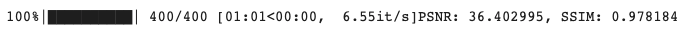

*   Evaluación del dataset con el último modelo (_epoch_ 100) entrenado con el propio dataset de Convallaria

**PSNR: 36.258200, SSIM: 0.977884**

Captura de pantalla 2021-09-12 a las 19.01.30.png

## Mouse actin dataset





*   Evaluación del dataset con el modelo preenetrenado por el dataset SSID sobre 800 imágenes

**PSNR: 27.962741, SSIM: 0.869285**

Captura de pantalla 2021-09-13 a las 17.14.05.png

*   Evaluación del dataset con el mejor modelo modelo entrenado con el propio dataset de Mouse Actin

**PSNR: 29.018915, SSIM: 0.875920**

Captura de pantalla 2021-09-14 a las 18.24.39.png

*   Evaluación del dataset con el último modelo (epoch 100) entrenado con el propio dataset de Convallaria

**PSNR: 27.915978, SSIM: 0.872565**

Captura de pantalla 2021-09-14 a las 18.49.32.png


## Datos de los entrenamientos


### Convallaria
Captura de pantalla 2021-09-12 a las 18.38.04.png

Captura de pantalla 2021-09-12 a las 18.38.08.png

### Mouse actin

WhatsApp Image 2021-09-14 at 08.14.38.jpeg

WhatsApp Image 2021-09-14 at 08.14.38 (1).jpeg